<a href="https://colab.research.google.com/github/GouravNayak/Development-of-a-Fully-Automated-RULA-Assessment-System-based-on-Computer-Vision/blob/main/RULA_based_posture_estimation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Necessary library imports**

In [ ]:
import os
import scipy.io
import scipy.misc

import PIL
import struct

from skimage.transform import resize

from keras.layers.merge import add, concatenate

import matplotlib.pyplot as plt
from matplotlib.pyplot import imshow
from matplotlib.patches import Rectangle

%matplotlib inline

from keras.preprocessing.image import load_img
from keras.preprocessing.image import img_to_array

import keras
from keras import Input, metrics
from keras.layers import MaxPooling2D, Conv2D, GlobalAveragePooling2D, Convolution2D, Flatten, Dense, Dropout, LeakyReLU, BatchNormalization, Activation
from keras.layers import Add, ZeroPadding2D, AveragePooling2D, MaxPooling2D, GlobalMaxPooling2D, Lambda, LeakyReLU, UpSampling2D
from keras.models import Model, Sequential, load_model, model_from_json
from keras.preprocessing import image
from keras.callbacks import ModelCheckpoint

import numpy as np
import random
import math
from numpy import clip, expand_dims, asarray
import cv2

import pandas as pd
import time
from google.colab.patches import cv2_imshow
from sklearn.model_selection import train_test_split
from matplotlib import pyplot
from PIL import Image

import pickle as pkl
from os import listdir
from os.path import isfile, join

**Pre-trained Neural network to detect person from image.We are calling it person detector network
Inspired from: https://github.com/experiencor/keras-yolo3**

In [ ]:
class WeightReader:
	def __init__(self, weight_file):
		with open(weight_file, 'rb') as w_f:
			major,	= struct.unpack('i', w_f.read(4))
			minor,	= struct.unpack('i', w_f.read(4))
			revision, = struct.unpack('i', w_f.read(4))
			if (major*10 + minor) >= 2 and major < 1000 and minor < 1000:
				w_f.read(8)
			else:
				w_f.read(4)
			transpose = (major > 1000) or (minor > 1000)
			binary = w_f.read()
		self.offset = 0
		self.all_weights = np.frombuffer(binary, dtype='float32')
 
	def read_bytes(self, size):
		self.offset = self.offset + size
		return self.all_weights[self.offset-size:self.offset]
 
	def load_weights(self, model):
		for i in range(106):
			try:
				conv_layer = model.get_layer('conv_' + str(i))
				print("loading weights of convolution #" + str(i))
				if i not in [81, 93, 105]:
					norm_layer = model.get_layer('bnorm_' + str(i))
					size = np.prod(norm_layer.get_weights()[0].shape)
					beta  = self.read_bytes(size) # bias
					gamma = self.read_bytes(size) # scale
					mean  = self.read_bytes(size) # mean
					var   = self.read_bytes(size) # variance
					weights = norm_layer.set_weights([gamma, beta, mean, var])
				if len(conv_layer.get_weights()) > 1:
					bias   = self.read_bytes(np.prod(conv_layer.get_weights()[1].shape))
					kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
					kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
					kernel = kernel.transpose([2,3,1,0])
					conv_layer.set_weights([kernel, bias])
				else:
					kernel = self.read_bytes(np.prod(conv_layer.get_weights()[0].shape))
					kernel = kernel.reshape(list(reversed(conv_layer.get_weights()[0].shape)))
					kernel = kernel.transpose([2,3,1,0])
					conv_layer.set_weights([kernel])
			except ValueError:
				print("no convolution #" + str(i))
 
	def reset(self):
		self.offset = 0

In [ ]:
def _conv_block(inp, convs, skip=True):
	x = inp
	count = 0
	for conv in convs:
		if count == (len(convs) - 2) and skip:
			skip_connection = x
		count += 1
		if conv['stride'] > 1: x = ZeroPadding2D(((1,0),(1,0)))(x) # peculiar padding as darknet prefer left and top
		x = Conv2D(conv['filter'],
				   conv['kernel'],
				   strides=conv['stride'],
				   padding='valid' if conv['stride'] > 1 else 'same', # peculiar padding as darknet prefer left and top
				   name='conv_' + str(conv['layer_idx']),
				   use_bias=False if conv['bnorm'] else True)(x)
		if conv['bnorm']: x = BatchNormalization(epsilon=0.001, name='bnorm_' + str(conv['layer_idx']))(x)
		if conv['leaky']: x = LeakyReLU(alpha=0.1, name='leaky_' + str(conv['layer_idx']))(x)
	return add([skip_connection, x]) if skip else x

def make_yolov3_model():
	input_image = Input(shape=(None, None, 3))
	# Layer  0 => 4
	x = _conv_block(input_image, [{'filter': 32, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 0},
								  {'filter': 64, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 1},
								  {'filter': 32, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 2},
								  {'filter': 64, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 3}])
	# Layer  5 => 8
	x = _conv_block(x, [{'filter': 128, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 5},
						{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 6},
						{'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 7}])
	# Layer  9 => 11
	x = _conv_block(x, [{'filter':  64, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 9},
						{'filter': 128, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 10}])
	# Layer 12 => 15
	x = _conv_block(x, [{'filter': 256, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 12},
						{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 13},
						{'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 14}])
	# Layer 16 => 36
	for i in range(7):
		x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 16+i*3},
							{'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 17+i*3}])
	skip_36 = x
	# Layer 37 => 40
	x = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 37},
						{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 38},
						{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 39}])
	# Layer 41 => 61
	for i in range(7):
		x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 41+i*3},
							{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 42+i*3}])
	skip_61 = x
	# Layer 62 => 65
	x = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 2, 'bnorm': True, 'leaky': True, 'layer_idx': 62},
						{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 63},
						{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 64}])
	# Layer 66 => 74
	for i in range(3):
		x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 66+i*3},
							{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 67+i*3}])
	# Layer 75 => 79
	x = _conv_block(x, [{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 75},
						{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 76},
						{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 77},
						{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 78},
						{'filter':  512, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 79}], skip=False)
	# Layer 80 => 82
	yolo_82 = _conv_block(x, [{'filter': 1024, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 80},
							  {'filter':  255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 81}], skip=False)
	# Layer 83 => 86
	x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 84}], skip=False)
	x = UpSampling2D(2)(x)
	x = concatenate([x, skip_61])
	# Layer 87 => 91
	x = _conv_block(x, [{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 87},
						{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 88},
						{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 89},
						{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 90},
						{'filter': 256, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True, 'layer_idx': 91}], skip=False)
	# Layer 92 => 94
	yolo_94 = _conv_block(x, [{'filter': 512, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 92},
							  {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 93}], skip=False)
	# Layer 95 => 98
	x = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True, 'leaky': True,   'layer_idx': 96}], skip=False)
	x = UpSampling2D(2)(x)
	x = concatenate([x, skip_36])
	# Layer 99 => 106
	yolo_106 = _conv_block(x, [{'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 99},
							   {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 100},
							   {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 101},
							   {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 102},
							   {'filter': 128, 'kernel': 1, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 103},
							   {'filter': 256, 'kernel': 3, 'stride': 1, 'bnorm': True,  'leaky': True,  'layer_idx': 104},
							   {'filter': 255, 'kernel': 1, 'stride': 1, 'bnorm': False, 'leaky': False, 'layer_idx': 105}], skip=False)
	model = Model(input_image, [yolo_82, yolo_94, yolo_106])
	return model

**Mount google drive for accessing pre-trained weights and saving files**

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


**Load the pre-trained person detector model and weights**

In [ ]:
# define the yolo v3 model
yolov3 = make_yolov3_model()
# load the weights
weight_reader = WeightReader('/content/gdrive/My Drive/Pose_Estimation_Dataset/yolov3.weights')

# set the weights
weight_reader.load_weights(yolov3)

# save the model to file
#yolov3.save('/content/gdrive/My Drive/Pose_Estimation_Dataset/person_detector_model.h5')
print('Person detector model loaded')

loading weights of convolution #0
loading weights of convolution #1
loading weights of convolution #2
loading weights of convolution #3
no convolution #4
loading weights of convolution #5
loading weights of convolution #6
loading weights of convolution #7
no convolution #8
loading weights of convolution #9
loading weights of convolution #10
no convolution #11
loading weights of convolution #12
loading weights of convolution #13
loading weights of convolution #14
no convolution #15
loading weights of convolution #16
loading weights of convolution #17
no convolution #18
loading weights of convolution #19
loading weights of convolution #20
no convolution #21
loading weights of convolution #22
loading weights of convolution #23
no convolution #24
loading weights of convolution #25
loading weights of convolution #26
no convolution #27
loading weights of convolution #28
loading weights of convolution #29
no convolution #30
loading weights of convolution #31
loading weights of convolution #32

**Helper functions for person detector network**

In [ ]:
class BoundBox:
  def __init__(self, xmin, ymin, xmax, ymax, objness = None, classes = None):
    self.xmin = xmin
    self.ymin = ymin
    self.xmax = xmax
    self.ymax = ymax
    self.objness = objness
    self.classes = classes
    self.label = -1
    self.score = -1

  def get_label(self):
    if self.label == -1:
      self.label = np.argmax(self.classes)
    
    return self.label
  
  def get_score(self):
    if self.score == -1:
      self.score = self.classes[self.get_label()]
    return self.get_score

def _sigmoid(x):
  return 1. /(1. + np.exp(-x))

def decode_netout(netout, anchors, obj_thresh, net_h, net_w):
	grid_h, grid_w = netout.shape[:2]
	nb_box = 3
	netout = netout.reshape((grid_h, grid_w, nb_box, -1))
	nb_class = netout.shape[-1] - 5
	boxes = []
	netout[..., :2]  = _sigmoid(netout[..., :2])
	netout[..., 4:]  = _sigmoid(netout[..., 4:])
	netout[..., 5:]  = netout[..., 4][..., np.newaxis] * netout[..., 5:]
	netout[..., 5:] *= netout[..., 5:] > obj_thresh
 
	for i in range(grid_h*grid_w):
		row = i / grid_w
		col = i % grid_w
		for b in range(nb_box):
			# 4th element is objectness score
			objectness = netout[int(row)][int(col)][b][4]
			if(objectness.all() <= obj_thresh): continue
			# first 4 elements are x, y, w, and h
			x, y, w, h = netout[int(row)][int(col)][b][:4]
			x = (col + x) / grid_w # center position, unit: image width
			y = (row + y) / grid_h # center position, unit: image height
			w = anchors[2 * b + 0] * np.exp(w) / net_w # unit: image width
			h = anchors[2 * b + 1] * np.exp(h) / net_h # unit: image height
			# last elements are class probabilities
			classes = netout[int(row)][col][b][5:]
			box = BoundBox(x-w/2, y-h/2, x+w/2, y+h/2, objectness, classes)
			boxes.append(box)
	return boxes

def correct_yolo_boxes(boxes, image_h, image_w, net_h, net_w):
	new_w, new_h = net_w, net_h
	for i in range(len(boxes)):
		x_offset, x_scale = (net_w - new_w)/2./net_w, float(new_w)/net_w
		y_offset, y_scale = (net_h - new_h)/2./net_h, float(new_h)/net_h
		boxes[i].xmin = int((boxes[i].xmin - x_offset) / x_scale * image_w)
		boxes[i].xmax = int((boxes[i].xmax - x_offset) / x_scale * image_w)
		boxes[i].ymin = int((boxes[i].ymin - y_offset) / y_scale * image_h)
		boxes[i].ymax = int((boxes[i].ymax - y_offset) / y_scale * image_h)

def _interval_overlap(interval_a, interval_b):
	x1, x2 = interval_a
	x3, x4 = interval_b
	if x3 < x1:
		if x4 < x1:
			return 0
		else:
			return min(x2,x4) - x1
	else:
		if x2 < x3:
			 return 0
		else:
			return min(x2,x4) - x3
 
def bbox_iou(box1, box2):
	intersect_w = _interval_overlap([box1.xmin, box1.xmax], [box2.xmin, box2.xmax])
	intersect_h = _interval_overlap([box1.ymin, box1.ymax], [box2.ymin, box2.ymax])
	intersect = intersect_w * intersect_h
	w1, h1 = box1.xmax-box1.xmin, box1.ymax-box1.ymin
	w2, h2 = box2.xmax-box2.xmin, box2.ymax-box2.ymin
	union = w1*h1 + w2*h2 - intersect
	return float(intersect) / union
 
def do_nms(boxes, nms_thresh):
	if len(boxes) > 0:
		nb_class = len(boxes[0].classes)
	else:
		return
	for c in range(nb_class):
		sorted_indices = np.argsort([-box.classes[c] for box in boxes])
		for i in range(len(sorted_indices)):
			index_i = sorted_indices[i]
			if boxes[index_i].classes[c] == 0: continue
			for j in range(i+1, len(sorted_indices)):
				index_j = sorted_indices[j]
				if bbox_iou(boxes[index_i], boxes[index_j]) >= nms_thresh:
					boxes[index_j].classes[c] = 0

# get all of the results above a threshold
def get_boxes(boxes, labels, thresh):
	v_boxes, v_labels, v_scores = list(), list(), list()
	# enumerate all boxes
	for box in boxes:
		# enumerate all possible labels
		for i in range(len(labels)):
			# check if the threshold for this label is high enough
			if box.classes[i] > thresh:
				v_boxes.append(box)
				v_labels.append(labels[i])
				v_scores.append(box.classes[i]*100)
				# don't break, many labels may trigger for one box
	return v_boxes, v_labels, v_scores

# draw all results
def draw_boxes(filename, v_boxes, v_labels, v_scores):
  
	# load the image
	data = pyplot.imread(filename)
	data = cv2.resize(data, (224, 224))
	# plot the image
	pyplot.imshow(data)
	# get the context for drawing boxes
	ax = pyplot.gca()
	# plot each box
	for i in range(len(v_boxes)):
		box = v_boxes[i]
		# get coordinates
		y1, x1, y2, x2 = box.ymin, box.xmin, box.ymax, box.xmax
		# calculate width and height of the box
		width, height = x2 - x1, y2 - y1
		# create the shape
		rect = Rectangle((x1, y1), width, height, fill=False, color='yellow', linewidth = '2')
		# draw the box
		ax.add_patch(rect)
		# draw text and score in top left corner
		label = "%s (%.3f)" % (v_labels[i], v_scores[i])
		pyplot.text(x1, y1, label, color='yellow')
	# show the plot
	pyplot.show()
 
def load_image_pixels(filename, shape):
  # load image to get its shape
  image = load_img(filename)
  image = image.resize((224,224))
  #width, height = image.size
  width, height = 224, 224
  # load image with required size
  image = load_img(filename, target_size=shape)
  image = img_to_array(image)

  # grayscale image normalization
  image = image.astype('float32')
  image /= 255.0

  # add a dimension so that we have one sample
  image = expand_dims(image, 0)
  return image, width, height

**Define anchor size, class_confidence_threshold and class label.**

In [ ]:
# define the anchors
anchors = [[116,90, 156,198, 373,326], [30,61, 62,45, 59,119], [10,13, 16,30, 33,23]]

# define the probability threshold for detected objects
class_threshold = 0.75

# define the class labels
labels = ["person"]

**Run this block to view output on any sample image with person**

Saving MVI_0449 Sitting -12.MP4_000487053.png to MVI_0449 Sitting -12.MP4_000487053.png
person 99.9828577041626
66 16 162 235


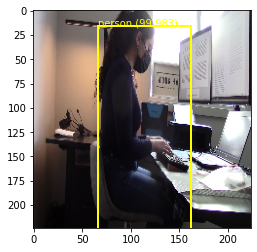

In [ ]:
from google.colab import files 
upload = files.upload()

for fn in upload.keys():
  photo_filename = '/content/' + fn

  # define the expected input shape for the model
  input_w, input_h = 224, 224

  image, image_w, image_h = load_image_pixels(photo_filename, (input_w, input_h))

  # make prediction
  yhat = yolov3.predict(image)
  # summarize the shape of the list of arrays
  #print([a.shape for a in yhat])
  
  boxes = list() 
  for i in range(len(yhat)):
    # decode the output of the network
    boxes += decode_netout(yhat[i][0], anchors[i], class_threshold, input_h, input_w)
 
  # correct the sizes of the bounding boxes for the shape of the image
  correct_yolo_boxes(boxes, image_h, image_w, input_h, input_w)

  # suppress non-maximal boxes
  do_nms(boxes, 0.5)

  # get the details of the detected objects
  v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)

  # summarize what we found
  for i in range(len(v_boxes)):
    print(v_labels[i], v_scores[i])
    box = v_boxes[i]
		# get coordinates
    x1, y1, x2, y2 = box.xmin, box.ymin, box.xmax, box.ymax
    print(x1, y1, x2, y2)
  
  # draw what we found
  draw_boxes(photo_filename, v_boxes, v_labels, v_scores)

**Helper functions for decoding posture estimation net results**

In [ ]:
root_path = '/content'
class_txt_annotation_file = str(root_path)+str('/gdrive/My Drive')+str('/Pose_Estimation_Dataset/Train_images_drive/body_model_class_names.txt')

In [ ]:
def read_classes(classes_path):
  with open(classes_path) as f:
    class_names = f.readlines()
  # stripping by default for space
  class_names = [c.strip() for c in class_names]
  return class_names

In [ ]:
model_class = read_classes(class_txt_annotation_file)

model_class_id_list = {k: v for k, v in zip(model_class, list(range(1, len(model_class)+1)))}
print(model_class_id_list)

{'left_shoulder': 1, 'right_shoulder': 2, 'left_elbow': 3, 'right_elbow': 4, 'left_wrist': 5, 'right_wrist': 6, 'left_trunk': 7, 'right_trunk': 8, 'left_knee': 9, 'right_knee': 10, 'left_ankle': 11, 'right_ankle': 12, 'left_knuckle': 13, 'right_knuckle': 14, 'nose': 15, 'left_eye': 16, 'right_eye': 17}


In [ ]:
body_model_img_size_width = 128
body_model_img_size_height = 128
body_channel = 1
classes_count = 17

In [ ]:
def extract_person_from_image(src_img_input, required_size=(body_model_img_size_width, body_model_img_size_height)):
  print('Detecting person in image: '+ str(src_img_input))
  person_complete_data = []
  src_image_read = plt.imread(src_img_input)
  src_image_read = cv2.resize(src_image_read, (224,224))

  image, image_w, image_h = load_image_pixels(src_img_input, (224, 224))
  # make prediction
  yhat = yolov3.predict(image)
  boxes = list()
  for i in range(len(yhat)):
    # decode the output of the network
    boxes += decode_netout(yhat[i][0], anchors[i], class_threshold, 224, 224)
 
  # correct the sizes of the bounding boxes for the shape of the image
  correct_yolo_boxes(boxes, image_h, image_w, 224, 224)

  # suppress non-maximal boxes
  do_nms(boxes, 0.5)

  # get the details of the detected objects
  v_boxes, v_labels, v_scores = get_boxes(boxes, labels, class_threshold)

  # summarize what we found
  boundary_threshold = 0.10
  print('No of person found: '+str(len(v_boxes)))
  if len(v_boxes)>0 and len(v_boxes)<5:
    
    if len(src_image_read.shape)==3:
      #print('converting the cropped image to gray')
      src_image_read = cv2.cvtColor(src_image_read, cv2.COLOR_RGB2GRAY)

    for i in range(len(v_boxes)):
      person = []
      #print(v_labels[i], v_scores[i])
      box = v_boxes[i]
      # get coordinates
      x1, y1, x2, y2 = box.xmin, box.ymin, box.xmax, box.ymax
      boundary_threshold_x = int(abs(x2-x1)*boundary_threshold)
      boundary_threshold_y = int(abs(y2-y1)*boundary_threshold)
      x1 = int(x1-boundary_threshold_x)
      x2 = int(x2+boundary_threshold_x)
      y1 = int(y1-boundary_threshold_y)
      y2 = int(y2+boundary_threshold_y)
      #avoid beyond tile error
      x1_lim = 0 if x1<0 else x1
      y1_lim = 0 if y1<0 else y1
      x2_lim = 224 if x2>224 else x2
      y2_lim = 224 if y2>224 else y2
      
      # print('person boundary: ')
      # print(x1_lim, y1_lim, x2_lim, y2_lim)

      person.append([x1_lim, y1_lim, x2_lim, y2_lim])
      # extract the person in grayscale format
      person_boundary = src_image_read[y1_lim:y2_lim, x1_lim:x2_lim]
      
      #cv2_imshow(person_boundary)
      person_image = Image.fromarray(person_boundary)
      # resize pixels to the model size
      person_image = person_image.resize(required_size)
      person_array = asarray(person_image,dtype=float)
      person_complete_data.append([person_array, person])

  return person_complete_data

def pre_process_body_image(src_body_img_arr,mode='train'):
  #print('Preprocessing image')
  #image standardization
  #image_norm = img_standardization(src_body_img_arr)
  image_norm = src_body_img_arr/255.0
  return image_norm

def predict_model(model_name, test_data):
  print('Predicting')
  start_time = time.time()
  prediction = model_name.predict(test_data)
  elapsed_time = time.time() - start_time
  print('Time taken to predict the result: ' + str(elapsed_time) + ' seconds')
  print(prediction)
  return prediction

**Posture estimation network architecture**

In [ ]:
def posture_estimation_model_func():

  # Instantiation
  Posture_Net = Sequential()

  #1st Convolutional Layer
  Posture_Net.add(Conv2D(filters=96, input_shape=(128,128,1), kernel_size=(11,11), strides=(4,4), padding='same'))
  Posture_Net.add(BatchNormalization())
  Posture_Net.add(Activation('relu'))
  Posture_Net.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

  #2nd Convolutional Layer
  Posture_Net.add(Conv2D(filters=256, kernel_size=(5, 5), strides=(1,1), padding='same'))
  Posture_Net.add(BatchNormalization())
  Posture_Net.add(Activation('relu'))
  Posture_Net.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

  #3rd Convolutional Layer
  Posture_Net.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
  Posture_Net.add(BatchNormalization())
  Posture_Net.add(Activation('relu'))

  #4th Convolutional Layer
  Posture_Net.add(Conv2D(filters=384, kernel_size=(3,3), strides=(1,1), padding='same'))
  Posture_Net.add(BatchNormalization())
  Posture_Net.add(Activation('relu'))

  #5th Convolutional Layer
  Posture_Net.add(Conv2D(filters=256, kernel_size=(3,3), strides=(1,1), padding='same'))
  Posture_Net.add(BatchNormalization())
  Posture_Net.add(Activation('relu'))

  Posture_Net.add(MaxPooling2D(pool_size=(2,2), strides=(2,2), padding='same'))

  #Passing it to a Fully Connected layer
  Posture_Net.add(Flatten())
  # 1st Fully Connected Layer
  Posture_Net.add(Dense(4096))
  Posture_Net.add(BatchNormalization())
  Posture_Net.add(Activation('relu'))
  # Add Dropout to prevent overfitting
  Posture_Net.add(Dropout(0.4))

  #2nd Fully Connected Layer
  Posture_Net.add(Dense(4096))
  Posture_Net.add(BatchNormalization())
  Posture_Net.add(Activation('relu'))
  #Add Dropout
  Posture_Net.add(Dropout(0.4))

  #3rd Fully Connected Layer
  Posture_Net.add(Dense(1000))
  Posture_Net.add(BatchNormalization())
  Posture_Net.add(Activation('relu'))
  #Add Dropout
  Posture_Net.add(Dropout(0.4))

  #Output Layer
  Posture_Net.add(Dense(34))
  Posture_Net.add(BatchNormalization())

  #Model Summary
  #Posture_Net.summary()
  return Posture_Net

**Load posture estimation model and weights**

In [ ]:
posture_estimation_model = posture_estimation_model_func()
posture_estimation_model.load_weights('/content/gdrive/My Drive/Pose_Estimation_Dataset/Model/weights_full_body_posture_246.hdf5')

**Decode detected posture to RULA score**

In [ ]:
# Initialize the body key points
left_knee_keypoint_coordinates = []
right_knee_keypoint_coordinates = []
left_ankle_keypoint_coordinates = []
right_ankle_keypoint_coordinates = []
right_trunk_keypoint_coordinates = []
left_trunk_keypoint_coordinates = []
right_shoulder_keypoint_coordinates = []
left_shoulder_keypoint_coordinates = []
left_elbow_keypoint_coordinates = []
right_elbow_keypoint_coordinates = []
right_wrist_keypoint_coordinates = []
left_wrist_keypoint_coordinates = []
right_knuckle_keypoint_coordinates = []
left_knuckle_keypoint_coordinates = []
left_eye_keypoint_coordinates = []
right_eye_keypoint_coordinates = []
neck_keypoint_coordinates = []
nose_keypoint_coordinates = []

head_keypoint_coordinates = []

**Initialize repositories for RULA Group-A, Group-B and Grand score table**

In [ ]:
rula_repo_table_path = '/content/gdrive/My Drive/Pose_Estimation_Dataset/RULA_repository_table.xlsx'
rula_group_a_df = pd.read_excel(rula_repo_table_path, 'group_A_table', header=None)
rula_group_b_df = pd.read_excel(rula_repo_table_path, 'group_B_table', header=None)
rula_grand_score_df = pd.read_excel(rula_repo_table_path, 'grand_score_table1', header=None)

**Helper functions to retrieve group scores from individual body scores**

In [ ]:
def find_rula_posture_score_a(upper_arm_score, lower_arm_score, wrist_posture_score, wrist_twist_score):
  upper_posture_score = 0

  upper_arm_df = rula_group_a_df.loc[(rula_group_a_df[0] == upper_arm_score) | (rula_group_a_df[0] == 0)]

  lower_arm_df = upper_arm_df.loc[(rula_group_a_df[1] == lower_arm_score) | (rula_group_a_df[0] == 0)]

  lower_arm_df = lower_arm_df.reset_index(drop = True)
  for col in range(lower_arm_df.shape[1]):
    if lower_arm_df[col][0] == wrist_posture_score:
      if lower_arm_df[col][1] == wrist_twist_score:
        upper_posture_score = lower_arm_df[col][2]
  print('Score A: '+str(upper_posture_score))
  return upper_posture_score


def find_rula_posture_score_b(neck_posture_score, trunk_posture_score, leg_posture_score):
  lower_posture_score = 0
  neck_df = rula_group_b_df.loc[(rula_group_b_df[0] == neck_posture_score) | (rula_group_b_df[0] == 0)]

  neck_df = neck_df.reset_index(drop=True)
  for col in range(neck_df.shape[1]):
    if neck_df[col][0] == trunk_posture_score:
      if neck_df[col][1] == leg_posture_score:
        lower_posture_score = neck_df[col][2]

  print('Score B: '+str(lower_posture_score))
  return lower_posture_score


def find_rula_grand_score(upper_body_posture_score, lower_body_posture_score):
  # Assumption
  upper_body_posture_score = upper_body_posture_score+2
  lower_body_posture_score = lower_body_posture_score+2
  grand_score = 0
  for col in range(rula_grand_score_df.shape[1]):
    if rula_grand_score_df[col][0] == lower_body_posture_score:
      for row in range(rula_grand_score_df.shape[0]):
        if rula_grand_score_df[0][row] == upper_body_posture_score:
          grand_score = rula_grand_score_df[col][row]

  print('Grand score is: '+str(grand_score))
  return grand_score

**Helper functions to calculate body scores from angles based on RULA**

In [ ]:
def calc_upper_arm_score(input_upper_arm_angle):
  print('Upper arm Flexion')
  if input_upper_arm_angle > 0:
    _is_upper_arm_flexion = True
    if 0 < input_upper_arm_angle <= 20:
      upper_arm_score = 1
    elif 20 < input_upper_arm_angle <= 45:
      upper_arm_score = 2
    elif 45 < input_upper_arm_angle <= 90:
      upper_arm_score = 3
    # Shoulder raised
    elif 90 <= input_upper_arm_angle:
      upper_arm_score = 4
  else:
    _is_upper_arm_flexion = True
    if -20 < input_upper_arm_angle <= 0:
      upper_arm_score = 1
    elif -45 < input_upper_arm_angle <= -20:
      upper_arm_score = 2
    elif -90 < input_upper_arm_angle <= -45:
      upper_arm_score = 3
    # Shoulder raised
    elif -90 <= input_upper_arm_angle:
      upper_arm_score = 4

  return _is_upper_arm_flexion, upper_arm_score

def calc_lower_arm_score(input_lower_arm_angle):
  lower_arm_score = 0

  if input_lower_arm_angle < 0:
    _is_upper_arm_flexion = False
    # lower_arm_score = 1
    print('Lower arm extension not possible')

  else:
    print('Lower arm flexion')
    _is_upper_arm_flexion = True
    if 60 < input_lower_arm_angle < 100:
      lower_arm_score = 1
    elif input_lower_arm_angle <= 60:
      lower_arm_score = 2
    elif input_lower_arm_angle >= 100:
      lower_arm_score = 2

  return _is_upper_arm_flexion, lower_arm_score

def calc_wrist_score(input_wrist_angle):
  
  if input_wrist_angle == 0:
    wrist_posture_score = 1
  elif 0<input_wrist_angle<=15:
    wrist_posture_score = 2
  elif input_wrist_angle > 15:
    wrist_posture_score = 3
    
  return wrist_posture_score

def calc_neck_score(input_neck_angle, input_neck_status):
  # Flexion or neutral
  if input_neck_status == True:
    if 0 <= input_neck_angle < 10:
      neck_posture_score = 1
    elif 10 <= input_neck_angle < 20:
      neck_posture_score = 2
    elif input_neck_angle >= 20:
      neck_posture_score = 3
  else:
    neck_posture_score = 4

  return neck_posture_score

def calc_neck_twist(left_shoulder_coordinate_pos, right_shoulder_coordinate_pos,
                        nose_coordinate_pos, img_view):
  if img_view=='front':
    right_shoulder_joint_coordinate = np.array([right_shoulder_coordinate_pos[0], right_shoulder_coordinate_pos[1]])
    left_shoulder_joint_coordinate = np.array([left_shoulder_coordinate_pos[0], left_shoulder_coordinate_pos[1]])
    nose_joint_coordinate = np.array([nose_coordinate_pos[0], left_shoulder_coordinate_pos[1]])

    dist_1 = int(math.sqrt(((nose_joint_coordinate[0]-right_shoulder_joint_coordinate[0])**2)+((nose_joint_coordinate[1]-right_shoulder_joint_coordinate[1])**2)))
    dist_2 = int(math.sqrt(((nose_joint_coordinate[0]-left_shoulder_joint_coordinate[0])**2)+((nose_joint_coordinate[1]-left_shoulder_joint_coordinate[1])**2)))
    
    print(dist_1, dist_2)
    
    if abs(dist_1-dist_2)>neck_twist_thres:
      _is_neck_side_twist_pos = True
    else:
      _is_neck_side_twist_pos = False
  else:
    print('Not an appropriate view. Needs front view')
    _is_neck_side_twist_pos = False

  return _is_neck_side_twist_pos

# distance between head and both shoulders must be same
def calc_neck_side_bending(trunk_coordinate_pos, neck_coordinate_pos, head_coordinate_pos, img_view):
  if img_view == 'front':
    point_c = np.array([trunk_coordinate_pos[0], trunk_coordinate_pos[1]])
    base_point = np.array([neck_coordinate_pos[0], neck_coordinate_pos[1]])
    point_b = np.array([head_coordinate_pos[0], head_coordinate_pos[1]])

    ba = point_b - base_point
    bc = point_c - base_point

    neck_bend_angle = np.degrees(np.math.atan2(np.linalg.det([ba, bc]), np.dot(ba, bc)))
    print('Func neck side bent angle: '+str(neck_bend_angle))
    
    neck_bend_angle = abs(neck_bend_angle) 
    
    if neck_bend_angle<=180:
      neck_bend_angle = 180 - neck_bend_angle

    if neck_bend_angle>=5:
      _is_neck_side_bent_pos = True
    else:
      _is_neck_side_bent_pos = False
  else:
    print('Not an appropriate view. Needs front view')
    _is_neck_side_bent_pos = False

  return _is_neck_side_bent_pos

def calc_trunk_score(input_trunk_angle):
  print('Trunk flexion')
  if 0 < input_trunk_angle <= 20:
    trunk_posture_score = 2
  elif 20 < input_trunk_angle <= 60:
    trunk_posture_score = 3
  elif input_trunk_angle > 60:
    trunk_posture_score = 4
  elif input_trunk_angle==0:
    print('Neutral trunk position')
    trunk_posture_score = 1

  return trunk_posture_score

# difference of length of opposite pairs of trunk and shoulder must be less than 10
def calc_trunk_twist(left_shoulder_coordinate_pos, right_shoulder_coordinate_pos,
                     left_trunk_coordinate_pos, right_trunk_coordinate_pos, 
                     trunk_side_bend_status, view_img):
  
  if view_img=='front':
    right_shoulder_joint_coordinate = np.array([right_shoulder_coordinate_pos[0], right_shoulder_coordinate_pos[1]])
    left_shoulder_joint_coordinate = np.array([left_shoulder_coordinate_pos[0], left_shoulder_coordinate_pos[1]])
    right_trunk_joint_coordinate = np.array([right_trunk_coordinate_pos[0], right_trunk_coordinate_pos[1]])
    left_trunk_joint_coordinate = np.array([left_trunk_coordinate_pos[0], left_trunk_coordinate_pos[1]])

    dist_1 = int(math.sqrt(((left_trunk_joint_coordinate[0]-right_shoulder_joint_coordinate[0])**2)+
                           ((left_trunk_joint_coordinate[1]-right_shoulder_joint_coordinate[1])**2)))
    dist_2 = int(math.sqrt(((right_trunk_joint_coordinate[0]-left_shoulder_joint_coordinate[0])**2)+
                           ((right_trunk_joint_coordinate[1]-left_shoulder_joint_coordinate[1])**2)))
    
    print(dist_1, dist_2)

    if abs(dist_1-dist_2)>trunk_twist_thres:
      _is_trunk_side_twist_pos = True
      if trunk_side_bend_status:
        print('Trunk side twist result can not be relied because of side bent')
        if abs(dist_1-dist_2)>10:
          print('Strong probability of trunk twisting')
          _is_trunk_side_twist_pos = True
        else:
          _is_trunk_side_twist_pos = False
    else:
      _is_trunk_side_twist_pos = False

  else:
    print('Not an appropriate view. Needs front view')
    _is_trunk_side_twist_pos = False

  return _is_trunk_side_twist_pos

def calc_wrist_bent(elbow_coordinate_pos, wrist_coordinate_pos, knuckle_coordinate_pos, img_view):

  point_c = np.array([elbow_coordinate_pos[0], elbow_coordinate_pos[1]])
  base_point = np.array([wrist_coordinate_pos[0], wrist_coordinate_pos[1]])
  point_b = np.array([knuckle_coordinate_pos[0], knuckle_coordinate_pos[1]])
  ba = point_b - base_point
  bc = point_c - base_point
    
  wrist_bent_angle = np.degrees(np.math.atan2(np.linalg.det([ba, bc]), np.dot(ba, bc)))
  print('Func wrist bent angle: '+str(wrist_bent_angle))

  wrist_bent_angle = abs(wrist_bent_angle)
     
  if wrist_bent_angle<=180:
    wrist_bent_angle = 180 - wrist_bent_angle

  wrist_bent_status = False
  print('Wrist bent angle: '+str(wrist_bent_angle))
  if img_view == 'front':
    if wrist_bent_angle>wrist_bend_thres:
      wrist_bent_status = True
    else:
      wrist_bent_status = False
  else:
    print('Not an appropriate view. Needs front view')
    wrist_bent_status = False
  return wrist_bent_status


def calc_trunk_side_bent(left_shoulder_coordinate_pos, right_shoulder_coordinate_pos, img_view):
  if img_view=='front':

    right_shoulder_joint_coordinate = np.array([right_shoulder_coordinate_pos[0], right_shoulder_coordinate_pos[1]])
    left_shoulder_joint_coordinate = np.array([left_shoulder_coordinate_pos[0], left_shoulder_coordinate_pos[1]])
    point_c = np.array([right_shoulder_coordinate_pos[0]*0.5, right_shoulder_coordinate_pos[1]])

    ba = left_shoulder_joint_coordinate - right_shoulder_joint_coordinate
    bc = point_c - right_shoulder_joint_coordinate

    trunk_side_bent_angle = np.degrees(np.math.atan2(np.linalg.det([ba, bc]), np.dot(ba, bc)))
    print('Func trunk side bend angle: '+str(trunk_side_bent_angle))

    trunk_side_bent_angle = 180  - abs(trunk_side_bent_angle)

    if trunk_side_bent_angle>=trunk_side_bend_thres:
      is_trunk_side_bent_pos = True
    else:
      is_trunk_side_bent_pos = False

  else:
    print('Not an appropriate view. Needs front view')
    is_trunk_side_bent_pos = False
  print('Trunk side bend angle: '+str(trunk_side_bent_angle))
  return is_trunk_side_bent_pos

# difference of length of right and left legs(ankle to knee) must be less than 10
def calc_leg_support(left_ankle_coordinate_pos, right_ankle_coordinate_pos):
  
  right_ankle_joint_coordinate = np.array([right_ankle_coordinate_pos[0], right_ankle_coordinate_pos[1]])
  left_ankle_joint_coordinate = np.array([left_ankle_coordinate_pos[0], left_ankle_coordinate_pos[1]])
    
  dist_1 = left_ankle_joint_coordinate[1]
  dist_2 = right_ankle_joint_coordinate[1]
  print(dist_1, dist_2)
  if abs(dist_1-dist_2)>10:
    _is_leg_supported_pos = False
  else:
    _is_leg_supported_pos = True

  return _is_leg_supported_pos

**Helper functions to calculate angles between individual body parts from detected body coordinates**

In [ ]:
# trunk,shoulder & shoulder,Elbow
# point_a[397,255.5], point_b[502,267], base_point[502.5,166.0]
def calc_upper_arm_angle(point_a, base_point, point_b):

  hip_joint_coordinate = np.array([point_a[0], point_a[1]])
  shoulder_joint_coordinate = np.array([base_point[0], base_point[1]])
  elbow_joint_coordinate = np.array([point_b[0], point_b[1]])

  ba = hip_joint_coordinate - shoulder_joint_coordinate
  bc = elbow_joint_coordinate - shoulder_joint_coordinate

  # positive if elbow is behind shoulder (Anti-clockwise) i.e extension
  upper_arm_angle = np.degrees(np.math.atan2(np.linalg.det([ba, bc]), np.dot(ba, bc)))

  return upper_arm_angle


# Extend the line connecting shoulder and elbow and find angle between upper arm and lower arm(elbow, wrist)
# Shoulder[502.5,166.0]; elbow[502, 267]; wrist[542.5,345.5]
def calc_lower_arm_angle(input_shoulder_joint_coordinate, input_elbow_joint_coordinate, input_wrist_joint_coordinate):

  point_c = np.array([input_shoulder_joint_coordinate[0], input_shoulder_joint_coordinate[1]])
  base_point = np.array([input_elbow_joint_coordinate[0], input_elbow_joint_coordinate[1]])
  point_b = np.array([input_wrist_joint_coordinate[0], input_wrist_joint_coordinate[1]])

  ba = point_b - base_point
  bc = point_c - base_point

  lower_arm_angle = np.degrees(np.math.atan2(np.linalg.det([ba, bc]), np.dot(ba, bc)))
  print('Func lower arm angle: '+str(lower_arm_angle))
  lower_arm_angle = 180 - abs(lower_arm_angle)

  return lower_arm_angle

def calc_lower_arm_work_midline(right_shoulder_joint_coordinate, left_shoulder_joint_coordinate,
                                right_wrist_coordinate, left_wrist_coordinate, img_view):
    if img_view == 'front':
      if right_shoulder_joint_coordinate[0] - left_shoulder_joint_coordinate[0] > 0:
        print('front view with left arm towards left side of image')
        if left_wrist_coordinate[0] > right_wrist_coordinate[0]:
          is_lower_arm_working_midline = False
        else:
          is_lower_arm_working_midline = True

      elif left_shoulder_joint_coordinate[0] - right_shoulder_joint_coordinate[0] > 0:
        print('front view with right arm towards left side of image')
        if right_wrist_coordinate[0] > left_wrist_coordinate[0]:
          is_lower_arm_working_midline = True
        else:
          is_lower_arm_working_midline = False
    # since it's not front view it can not be computed
    elif img_view == 'left':
      print('a left view image')
      if (left_wrist_coordinate[0] > right_wrist_coordinate[0]) and (left_wrist_coordinate[1] <= right_wrist_coordinate[1]):
        is_lower_arm_working_midline = True
      else:
        is_lower_arm_working_midline = False
    elif img_view == 'right':
      print('a right view image')
      if (right_wrist_coordinate[0] > left_wrist_coordinate[0]) and (right_wrist_coordinate[1] <= left_wrist_coordinate[1]):
        is_lower_arm_working_midline = True
      else:
        is_lower_arm_working_midline = False

    return is_lower_arm_working_midline

# line between elbow and wrist extended and interior angle is calculated between lower arm and wrist(wrist, knuckle)
def calc_wrist_posture_angle(elbow_joint_coordinate, wrist_joint_coordinate, knuckle_joint_coordinate):
    point_c = np.array([elbow_joint_coordinate[0], elbow_joint_coordinate[1]])
    base_point = np.array([wrist_joint_coordinate[0], wrist_joint_coordinate[1]])
    point_b = np.array([knuckle_joint_coordinate[0], knuckle_joint_coordinate[1]])
    ba = point_b - base_point
    bc = point_c - base_point
    
    wrist_angle = np.degrees(np.math.atan2(np.linalg.det([ba, bc]), np.dot(ba, bc)))
    print('Func wrist angle: '+str(wrist_angle))

    if wrist_angle<0:
      # clockwise
      print('wrist flexion')
      wrist_status = True
    elif wrist_angle>0:
      # anticlockwise
      print('wrist extension')
      wrist_status = False
    else:
      # in same line
      print('neutral')
      wrist_status = True

    wrist_angle = abs(wrist_angle)
     
    if wrist_angle<=180:
      wrist_angle = 180 - wrist_angle

    return wrist_angle

# [397,255.5], [533, 73.5], [639.5, 6.5]
def calc_neck_posture_angle(trunk_joint_coordinate, neck_joint_coordinate, head_joint_coordinate, image_view):
    point_c = np.array([trunk_joint_coordinate[0], trunk_joint_coordinate[1]])
    base_point = np.array([neck_joint_coordinate[0], neck_joint_coordinate[1]])
    point_b = np.array([head_joint_coordinate[0], head_joint_coordinate[1]])

    ba = point_b - base_point
    bc = point_c - base_point

    # positive if head is behind neck i.e extension
    neck_angle = np.degrees(np.math.atan2(np.linalg.det([ba, bc]), np.dot(ba, bc)))
    print('Func neck angle: '+str(neck_angle))
    print('View of the image: '+str(image_view))
    if image_view =='left':
      print('left view')
      if neck_angle<0:
        neck_status = True
        print('Neck flexion')
      elif neck_angle>0:
        neck_status = False
        print('Neck extension')
      else:
        neck_status = True
        print('Neck neutral')
    elif image_view =='right':
      print('right view')
      if neck_angle>0:
        neck_status = True
        print('Neck flexion')
      elif neck_angle<0:
        neck_status = False
        print('Neck extension')
      else:
        neck_status = True
        print('Neck neutral')

    
    neck_angle = abs(neck_angle) 
    
    if neck_angle<=180:
      neck_angle = 180 - neck_angle
    
    return neck_status, neck_angle

# [395, 428.5], [370.5, 247.5], [486, 68.5]
def calc_trunk_posture_angle(vertical_joint_coordinate, trunk_joint_coordinate, neck_joint_coordinate, image_view):
  point_b = np.array([vertical_joint_coordinate[0], vertical_joint_coordinate[1]])
  base_point = np.array([trunk_joint_coordinate[0], trunk_joint_coordinate[1]])
  point_c = np.array([neck_joint_coordinate[0], neck_joint_coordinate[1]])

  ba = point_b - base_point
  bc = point_c - base_point

  trunk_angle = np.degrees(np.math.atan2(np.linalg.det([ba, bc]), np.dot(ba, bc)))
  
  print('Func trunk angle: '+str(trunk_angle))
  if image_view=='left':
    print('left view image')
  elif image_view=='right':
    print('right view image')
  else:
    print('front view image')
  
  trunk_angle = abs(trunk_angle)

  return trunk_angle

**Function to decode predictions from postue estimation network**

In [ ]:
def decode_pose_estimate_net(input_test_img_name_s1, input_extracted_test_body_s1, model_name):
      input_test_label_data_list_s1 = []
      pre_processed_test_image_s1 = pre_process_body_image(input_extracted_test_body_s1[0], mode='test')
      body_bbox_s1_x1 = input_extracted_test_body_s1[1][0][0]
      body_bbox_s1_y1 = input_extracted_test_body_s1[1][0][1]
      body_bbox_s1_x2 = input_extracted_test_body_s1[1][0][2]
      body_bbox_s1_y2 = input_extracted_test_body_s1[1][0][3]
        
      x_test_s1 = np.array(pre_processed_test_image_s1)
      x_test_s1 = np.array(x_test_s1).reshape([-1, body_model_img_size_width, body_model_img_size_height, body_channel])
      print(x_test_s1.shape)
      
      # predict keypoints in image
      prediction_s1 = predict_model(model_name, x_test_s1)

      test_src_img_s1 = cv2.imread(input_test_img_name_s1,cv2.IMREAD_COLOR)
      test_src_img_s1 = cv2.resize(test_src_img_s1, (224, 224))
      test_img_s1_height, test_img_s1_width, test_img_channel = test_src_img_s1.shape
      

      body_bbox_s1_width = int(abs(body_bbox_s1_x1 - body_bbox_s1_x2))
      body_bbox_s1_height = int(abs(body_bbox_s1_y1 - body_bbox_s1_y2))

      body_bbox_center_x1 = int(body_bbox_s1_x1+(body_bbox_s1_width*0.5))
      body_bbox_center_y1 = int(body_bbox_s1_y1+(body_bbox_s1_height*0.5))
      # calculate absolute coordinates of labels
      for test_i in range(0, classes_count):
        test_img_label_s1 = ''
        test_s1_x_coordinate =  int(body_bbox_s1_x1+((prediction_s1[0][2*test_i]*(224/128))*(body_bbox_s1_width/224)))
        test_s1_y_coordinate = int(body_bbox_s1_y1 +((prediction_s1[0][(2*test_i)+1]*(224/128))*(body_bbox_s1_height/224)))

        for test_class_n, test_class_id in model_class_id_list.items():
          if test_class_id==test_i+1:
            test_img_label_s1 = test_class_n
        input_test_label_data_list_s1.append([test_s1_x_coordinate, test_s1_y_coordinate, test_img_label_s1])
      
      # calculate neck coordinate
      input_test_label_data_list_s1.append([abs(input_test_label_data_list_s1[0][0]+input_test_label_data_list_s1[1][0])*0.5,
                                            abs(input_test_label_data_list_s1[0][1]+input_test_label_data_list_s1[1][1])*0.50,
                                            'neck'])
      head_y = abs(input_test_label_data_list_s1[17][1] - input_test_label_data_list_s1[0][1])
      input_test_label_data_list_s1.append([abs(input_test_label_data_list_s1[14][0]+input_test_label_data_list_s1[15][0])*0.5,
                                            (abs(input_test_label_data_list_s1[14][1]+input_test_label_data_list_s1[15][1])*0.5)-head_y,
                                            'head'])
        
      # Plot keypoints
      for test_label_data in input_test_label_data_list_s1:
        print('Plotting point '+str(int(test_label_data[0])) + str(', ' )+ str(int(test_label_data[1])) + ' for label '+ str(test_label_data[2]))
        test_src_img_s1 = cv2.circle(img=test_src_img_s1, center=(int(test_label_data[0]), int(test_label_data[1])), radius=2,
                                                color=(255, 0, 0), thickness=-1)    
      cv2_imshow(test_src_img_s1)
      return input_test_label_data_list_s1

**user inputs, test image directory and thresholds to refine detected key points**

In [ ]:
test_img_root_path='/content/gdrive/My Drive/Pose_Estimation_Dataset/Test_images'
is_rested = True
neck_twist_thres = 15
neck_side_bend_thres = 8
trunk_twist_thres = 6
trunk_side_bend_thres = 15
wrist_bend_thres = 15

**Helper function that detects RULA scores from front and side image**

In [ ]:
def plot_estimate_rula_score(input_test_front_img, input_test_side_img, img_view):
  # Fetch the side and front view image
  test_img_front = input_test_front_img
  test_img_side = input_test_side_img
  if img_view=='R':
    view = 'right'
  elif img_view=='L':
    view = 'left'
  extracted_test_bodies_side = extract_person_from_image(test_img_side)

  if len(extracted_test_bodies_side)>0:
    print('No of people detected: '+str(len(extracted_test_bodies_side)))
    for extracted_test_body_side in extracted_test_bodies_side:
      test_label_data_list_side=[]
      test_label_data_list_side = decode_pose_estimate_net(test_img_side,extracted_test_body_side, posture_estimation_model)
      # continue
      body_keypoint_df = pd.DataFrame(test_label_data_list_side)
      body_keypoint_df = body_keypoint_df.set_index([2])
      left_shoulder_keypoint_df = body_keypoint_df.loc['left_shoulder']
      left_shoulder_keypoint_coordinates = [left_shoulder_keypoint_df[0], left_shoulder_keypoint_df[1]]
      right_shoulder_keypoint_df = body_keypoint_df.loc['right_shoulder']
      right_shoulder_keypoint_coordinates = [right_shoulder_keypoint_df[0], right_shoulder_keypoint_df[1]]

      mid_shoulder_keypoint_coordinates = [abs(left_shoulder_keypoint_df[0]+right_shoulder_keypoint_df[0])*0.5,
                                        abs(left_shoulder_keypoint_df[1]+right_shoulder_keypoint_df[1])*0.5]

      neck_keypoint_df = body_keypoint_df.loc['neck']
      neck_keypoint_coordinates = [neck_keypoint_df[0], neck_keypoint_df[1]]
      nose_keypoint_df = body_keypoint_df.loc['nose']
      nose_keypoint_coordinates = [nose_keypoint_df[0], nose_keypoint_df[1]]

      head_keypoint_df = body_keypoint_df.loc['head']
      head_keypoint_coordinates = [head_keypoint_df[0], head_keypoint_df[1]]
      left_elbow_keypoint_df = body_keypoint_df.loc['left_elbow']
      left_elbow_keypoint_coordinates = [left_elbow_keypoint_df[0], left_elbow_keypoint_df[1]]
      right_elbow_keypoint_df = body_keypoint_df.loc['right_elbow']
      right_elbow_keypoint_coordinates = [right_elbow_keypoint_df[0], right_elbow_keypoint_df[1]]
      left_wrist_keypoint_df = body_keypoint_df.loc['left_wrist']
      left_wrist_keypoint_coordinates = [left_wrist_keypoint_df[0], left_wrist_keypoint_df[1]]
      right_wrist_keypoint_df = body_keypoint_df.loc['right_wrist']
      right_wrist_keypoint_coordinates = [right_wrist_keypoint_df[0], right_wrist_keypoint_df[1]]
      left_knuckle_keypoint_df = body_keypoint_df.loc['left_knuckle']
      left_knuckle_keypoint_coordinates = [left_knuckle_keypoint_df[0], left_knuckle_keypoint_df[1]]
      right_knuckle_keypoint_df = body_keypoint_df.loc['right_knuckle']
      right_knuckle_keypoint_coordinates = [right_knuckle_keypoint_df[0], right_knuckle_keypoint_df[1]]
        
      left_trunk_keypoint_df = body_keypoint_df.loc['left_trunk']
      left_trunk_keypoint_coordinates = [left_trunk_keypoint_df[0], left_trunk_keypoint_df[1]]
      right_trunk_keypoint_df = body_keypoint_df.loc['right_trunk']
      right_trunk_keypoint_coordinates = [right_trunk_keypoint_df[0], right_trunk_keypoint_df[1]]

      mid_trunk_keypoint_coordinates = [abs(left_trunk_keypoint_df[0]+right_trunk_keypoint_df[0])*0.5,
                                        abs(left_trunk_keypoint_df[1]+right_trunk_keypoint_df[1])*0.5]

      mid_vertical_keypoint_coordinates = [abs(left_trunk_keypoint_df[0]+right_trunk_keypoint_df[0])*0.5,
                                          nose_keypoint_df[1]]

      # Upper Arm Angle
      img_left_upper_arm_angle = calc_upper_arm_angle(left_trunk_keypoint_coordinates, 
                                                      left_shoulder_keypoint_coordinates, left_elbow_keypoint_coordinates)
      print('Left Upper arm angle: '+str(img_left_upper_arm_angle))
      # status: true means flexion
      img_left_upper_arm_status, img_left_upper_arm_score = calc_upper_arm_score(img_left_upper_arm_angle)
      print('Corresponding Score: '+ str(img_left_upper_arm_score))
      img_right_upper_arm_angle = calc_upper_arm_angle(right_trunk_keypoint_coordinates, 
                                                      right_shoulder_keypoint_coordinates, right_elbow_keypoint_coordinates)
      print('Right Upper arm angle: '+str(img_right_upper_arm_angle))


      img_right_upper_arm_status, img_right_upper_arm_score = calc_upper_arm_score(img_right_upper_arm_angle)
      print('Corresponding Score: '+ str(img_right_upper_arm_score))

      upper_body_lean_angle = calc_trunk_posture_angle(mid_vertical_keypoint_coordinates, mid_trunk_keypoint_coordinates, 
                                                mid_shoulder_keypoint_coordinates, view)
      print('Upper body lean angle: ' +str(upper_body_lean_angle))
      
      if 20<=upper_body_lean_angle<=70 and img_left_upper_arm_status and is_rested:
        _is_operator_lean = True
        print('Operator leaned')
        img_left_upper_arm_score = img_left_upper_arm_score - 1
        img_right_upper_arm_score = img_right_upper_arm_score - 1
        print('Upper arm score updated due to lean posture: '+str(img_left_upper_arm_score))
      else:
        _is_operator_lean = False
        print('Operator not leaned')
      
      # Lower Arm Posture
      img_left_lower_arm_angle = calc_lower_arm_angle(left_shoulder_keypoint_coordinates, 
                                                      left_elbow_keypoint_coordinates, left_wrist_keypoint_coordinates)
      print('Left Lower arm angle: '+str(img_left_lower_arm_angle))
      left_lower_arm_status, img_left_lower_arm_score = calc_lower_arm_score(img_left_lower_arm_angle)
      print('Corresponding Score: '+ str(img_left_lower_arm_score))
      img_right_lower_arm_angle = calc_lower_arm_angle(right_shoulder_keypoint_coordinates, 
                                                      right_elbow_keypoint_coordinates, right_wrist_keypoint_coordinates)
      print('Right Lower arm angle: '+str(img_right_lower_arm_angle))
      right_lower_arm_status, img_right_lower_arm_score = calc_lower_arm_score(img_right_lower_arm_angle)
      print('Corresponding Score: '+ str(img_right_lower_arm_score))

      print('Left wrist posture')
      img_left_wrist_angle = calc_wrist_posture_angle(left_elbow_keypoint_coordinates, 
                                                      left_wrist_keypoint_coordinates, left_knuckle_keypoint_coordinates)
      print('Left wrist angle: '+str(img_left_wrist_angle))
      img_left_wrist_score = calc_wrist_score(img_left_wrist_angle)
      print('Corresponding Score: '+ str(img_left_wrist_score))

      print('Right wrist posture')
      img_right_wrist_angle = calc_wrist_posture_angle(right_elbow_keypoint_coordinates, 
                                                      right_wrist_keypoint_coordinates, right_knuckle_keypoint_coordinates)
      print('Right wrist angle: '+str(img_right_wrist_angle))
      img_right_wrist_score = calc_wrist_score(img_right_wrist_angle)
      print('Corresponding Score: '+ str(img_right_wrist_score))

      is_left_wrist_twist = False
      if is_left_wrist_twist:
        img_left_wrist_twist_score = 2
      else:
        img_left_wrist_twist_score = 1

      print('Left Wrist Twist Score: '+ str(img_left_wrist_twist_score))

      is_right_wrist_twist = False
      if is_right_wrist_twist:
        img_right_wrist_twist_score = 2
      else:
        img_right_wrist_twist_score = 1

      print('Right Wrist Twist Score: '+ str(img_right_wrist_twist_score))

      # Neck Posture
      if nose_keypoint_coordinates[0]>0:
        img_neck_status, img_neck_angle = calc_neck_posture_angle(mid_trunk_keypoint_coordinates, neck_keypoint_coordinates, 
                                                head_keypoint_coordinates, view)
      else:
        print('Nose coordinates are unavailable probably because face is undetected')
        img_neck_angle = 0
        img_neck_status = True

      print('Neck angle: '+str(img_neck_angle))
      print('Neck Flexion: '+str(img_neck_status))
      img_neck_score = calc_neck_score(img_neck_angle, img_neck_status)
      print('Corresponding Score: '+ str(img_neck_score))

      # Trunk Posture
      img_trunk_angle = calc_trunk_posture_angle(mid_vertical_keypoint_coordinates, mid_trunk_keypoint_coordinates, 
                                                neck_keypoint_coordinates, view)
      print('trunk angle: '+str(img_trunk_angle))
      img_trunk_score = calc_trunk_score(img_trunk_angle)
      print('Corresponding Score: '+ str(img_trunk_score))
      
      # Side body calculation ends
      break
  # Front body starts
  extracted_test_bodies_front = extract_person_from_image(test_img_front)

  if len(extracted_test_bodies_front)>0:
    print('No of people detected: '+str(len(extracted_test_bodies_front)))
    for extracted_test_body_front in extracted_test_bodies_front:
      test_label_data_list_front=[]
      test_label_data_list_front = decode_pose_estimate_net(test_img_front,extracted_test_body_front, posture_estimation_model)
      # continue
      body_keypoint_df = pd.DataFrame(test_label_data_list_front)
      body_keypoint_df = body_keypoint_df.set_index([2])
      left_shoulder_keypoint_df = body_keypoint_df.loc['left_shoulder']
      left_shoulder_keypoint_coordinates = [left_shoulder_keypoint_df[0], left_shoulder_keypoint_df[1]]
      right_shoulder_keypoint_df = body_keypoint_df.loc['right_shoulder']
      right_shoulder_keypoint_coordinates = [right_shoulder_keypoint_df[0], right_shoulder_keypoint_df[1]]

      mid_shoulder_keypoint_coordinates = [abs(left_shoulder_keypoint_df[0]+right_shoulder_keypoint_df[0])*0.5,
                                        abs(left_shoulder_keypoint_df[1]+right_shoulder_keypoint_df[1])*0.5]

      neck_keypoint_df = body_keypoint_df.loc['neck']
      neck_keypoint_coordinates = [neck_keypoint_df[0], neck_keypoint_df[1]]
      nose_keypoint_df = body_keypoint_df.loc['nose']
      nose_keypoint_coordinates = [nose_keypoint_df[0], nose_keypoint_df[1]]
      right_eye_keypoint_df = body_keypoint_df.loc['right_eye']
      right_eye_keypoint_coordinates = [right_eye_keypoint_df[0], right_eye_keypoint_df[1]]
      left_eye_keypoint_df = body_keypoint_df.loc['left_eye']
      left_eye_keypoint_coordinates = [left_eye_keypoint_df[0], left_eye_keypoint_df[1]]
      head_keypoint_df = body_keypoint_df.loc['head']
      head_keypoint_coordinates = [head_keypoint_df[0], head_keypoint_df[1]]
      left_elbow_keypoint_df = body_keypoint_df.loc['left_elbow']
      left_elbow_keypoint_coordinates = [left_elbow_keypoint_df[0], left_elbow_keypoint_df[1]]
      right_elbow_keypoint_df = body_keypoint_df.loc['right_elbow']
      right_elbow_keypoint_coordinates = [right_elbow_keypoint_df[0], right_elbow_keypoint_df[1]]
      left_wrist_keypoint_df = body_keypoint_df.loc['left_wrist']
      left_wrist_keypoint_coordinates = [left_wrist_keypoint_df[0], left_wrist_keypoint_df[1]]
      right_wrist_keypoint_df = body_keypoint_df.loc['right_wrist']
      right_wrist_keypoint_coordinates = [right_wrist_keypoint_df[0], right_wrist_keypoint_df[1]]
      left_knuckle_keypoint_df = body_keypoint_df.loc['left_knuckle']
      left_knuckle_keypoint_coordinates = [left_knuckle_keypoint_df[0], left_knuckle_keypoint_df[1]]
      right_knuckle_keypoint_df = body_keypoint_df.loc['right_knuckle']
      right_knuckle_keypoint_coordinates = [right_knuckle_keypoint_df[0], right_knuckle_keypoint_df[1]]
        
      left_trunk_keypoint_df = body_keypoint_df.loc['left_trunk']
      left_trunk_keypoint_coordinates = [left_trunk_keypoint_df[0], left_trunk_keypoint_df[1]]
      right_trunk_keypoint_df = body_keypoint_df.loc['right_trunk']
      right_trunk_keypoint_coordinates = [right_trunk_keypoint_df[0], right_trunk_keypoint_df[1]]

      mid_trunk_keypoint_coordinates = [abs(left_trunk_keypoint_df[0]+right_trunk_keypoint_df[0])*0.5,
                                        abs(left_trunk_keypoint_df[1]+right_trunk_keypoint_df[1])*0.5]

      left_knee_keypoint_df = body_keypoint_df.loc['left_knee']
      left_knee_keypoint_coordinates = [left_knee_keypoint_df[0], left_knee_keypoint_df[1]]
      right_knee_keypoint_df = body_keypoint_df.loc['right_knee']
      right_knee_keypoint_coordinates = [right_knee_keypoint_df[0], right_knee_keypoint_df[1]]

      mid_vertical_keypoint_coordinates = [abs(left_trunk_keypoint_df[0]+right_trunk_keypoint_df[0])*0.5,
                                          nose_keypoint_df[1]]

      left_ankle_keypoint_df = body_keypoint_df.loc['left_ankle']
      left_ankle_keypoint_coordinates = [left_ankle_keypoint_df[0],left_ankle_keypoint_df[1]]
      right_ankle_keypoint_df = body_keypoint_df.loc['right_ankle']
      right_ankle_keypoint_coordinates = [right_ankle_keypoint_df[0],right_ankle_keypoint_df[1]]

      if (left_shoulder_keypoint_coordinates[1]-left_elbow_keypoint_coordinates[1])>=-10:
        print(left_shoulder_keypoint_coordinates[1], left_elbow_keypoint_coordinates[1])
        _is_left_shoulder_abducted = True  
      else:
        _is_left_shoulder_abducted = False

      if (right_shoulder_keypoint_coordinates[1]-right_elbow_keypoint_coordinates[1])>=-10:
        print(right_shoulder_keypoint_coordinates[1],right_elbow_keypoint_coordinates[1])
        _is_right_shoulder_abducted = True  
      else:
        _is_right_shoulder_abducted = False

      print('Is Left Shoulder Abducted: '+str(_is_left_shoulder_abducted))
      if _is_left_shoulder_abducted:
        img_left_upper_arm_score = img_left_upper_arm_score + 1
        print('left upper arm score updated due to abduction: '+str(img_left_upper_arm_score))
        
        
      print('Is Right Shoulder Abducted: '+str(_is_right_shoulder_abducted))
      if _is_right_shoulder_abducted:
        img_right_upper_arm_score = img_right_upper_arm_score + 1
        print('right upper arm score updated due to abduction: '+str(img_right_upper_arm_score))
        

      # Shoulder is elevated if upper arm angle>90*
      _is_left_shoulder_raised = False if abs(img_left_upper_arm_angle)>=90 else False
      print('Is left Shoulder raised: '+str(_is_left_shoulder_raised))
      if _is_left_shoulder_raised:
        img_left_upper_arm_score = img_left_upper_arm_score + 1
        print('left upper arm score updated due to shoulder raise: '+str(img_left_upper_arm_score))
        
      _is_right_shoulder_raised = False if abs(img_right_upper_arm_angle)>=90 else False
      print('Is right Shoulder raised: '+str(_is_right_shoulder_raised))
      if _is_right_shoulder_raised:
        img_right_upper_arm_score = img_right_upper_arm_score + 1
        print('right upper arm score updated due to shoulder raise: '+str(img_right_upper_arm_score))
        

      if img_right_upper_arm_score==0:
        print('Right Upper arm score was 1 and made 0 because posture is leaned and rested')
        img_right_upper_arm_score = 1
      if img_left_upper_arm_score==0:
        print('Left Upper arm score was 1 and made 0 because posture is leaned and rested')
        img_left_upper_arm_score = 1

      print('Final left upper arm score: '+str(img_left_upper_arm_score))
      print('Final right upper arm score: '+str(img_right_upper_arm_score))

      img_lower_arm_working_midline = calc_lower_arm_work_midline(right_shoulder_keypoint_coordinates,
                                                                  left_shoulder_keypoint_coordinates,
                                                                  right_ankle_keypoint_coordinates, 
                                                                  left_ankle_keypoint_coordinates, 
                                                                  'front')
      print('is lower arm working midline '+str(img_lower_arm_working_midline))
      if img_lower_arm_working_midline:
        print('Lower arm score updated due to arm working midline posture')
        img_left_lower_arm_score = img_left_lower_arm_score + 1
        img_right_lower_arm_score = img_right_lower_arm_score + 1

      print('Final left lower arm score: '+str(img_left_lower_arm_score))
      print('Final right lower arm score: '+str(img_right_lower_arm_score))

      # is_left_wrist_bent_away_midline = calc_wrist_bent(left_elbow_keypoint_coordinates, left_wrist_keypoint_coordinates, 
      #                                                   left_knuckle_keypoint_coordinates,'front')
      is_left_wrist_bent_away_midline = False

      print('Is left wrist bent away from mid: '+str(is_left_wrist_bent_away_midline))
      if is_left_wrist_bent_away_midline:
        img_left_wrist_score = img_left_wrist_score+1
        print('Left Wrist Score updated because wrist bent away midline: '+ str(img_left_wrist_score))

      # is_right_wrist_bent_away_midline = calc_wrist_bent(right_elbow_keypoint_coordinates,right_wrist_keypoint_coordinates, 
      #                                                    right_knuckle_keypoint_coordinates,'front')
      is_right_wrist_bent_away_midline=False
      print('Is right wrist bent away from mid: '+str(is_right_wrist_bent_away_midline))
      if is_right_wrist_bent_away_midline:
        img_right_wrist_score = img_right_wrist_score+1
        print('Right Wrist Score updated because wrist bent away midline: '+ str(img_right_wrist_score))
      
      if nose_keypoint_coordinates[0]>0:
        img_neck_twist = calc_neck_twist(left_shoulder_keypoint_coordinates, right_shoulder_keypoint_coordinates, 
                                        nose_keypoint_coordinates, 'front')
        img_neck_side_bending = calc_neck_side_bending(mid_trunk_keypoint_coordinates, neck_keypoint_coordinates,
                                                      head_keypoint_coordinates, 'front')
      else:
        print('Nose coordinates are unavailable probably because face is undetected')
        img_neck_twist = False
        img_neck_side_bending = False

      print('is neck twisted: '+str(img_neck_twist))
      if img_neck_twist:
        img_neck_score = img_neck_score + 1
        print('Neck Score updated due to neck twisting: '+ str(img_neck_score))
      
      print('is neck side bending: '+str(img_neck_side_bending))
      if img_neck_side_bending:
        img_neck_score = img_neck_score + 1
        print('Neck Score updated due to side bending: '+ str(img_neck_score))
        
      img_trunk_side_bending = calc_trunk_side_bent(left_shoulder_keypoint_coordinates, right_shoulder_keypoint_coordinates, 'front')
      print('is trunk side bent: '+str(img_trunk_side_bending))
        
      if img_trunk_side_bending:
        img_trunk_score = img_trunk_score + 1
        print('Trunk Score updated due to side bending: '+ str(img_trunk_score))
      
      img_trunk_twist = calc_trunk_twist(left_shoulder_keypoint_coordinates, right_shoulder_keypoint_coordinates, 
                                        left_trunk_keypoint_coordinates, right_trunk_keypoint_coordinates, img_trunk_side_bending, 'front')
      print('is trunk twist: '+str(img_trunk_twist))
      if img_trunk_twist:
        img_trunk_score = img_trunk_score + 1
        print('Trunk Score updated due to twisting: '+ str(img_trunk_score))

      img_leg_support_status = calc_leg_support(left_ankle_keypoint_coordinates, right_ankle_keypoint_coordinates)
      print('is leg supported: '+str(img_leg_support_status))
      if img_leg_support_status:
        img_leg_posture_score = 1
      else:
        img_leg_posture_score = 2 
      print('Corresponding Score: '+ str(img_leg_posture_score))

      # front view calculation ends
      break

    # Main Rula score estimation starts
    print('Finding posture score for left side group A')
    print(img_left_upper_arm_score, img_left_lower_arm_score, img_left_wrist_score, img_left_wrist_twist_score)

    left_posture_score_a = find_rula_posture_score_a(upper_arm_score=img_left_upper_arm_score,
                                                    lower_arm_score=img_left_lower_arm_score,
                                                    wrist_posture_score=img_left_wrist_score,
                                                    wrist_twist_score=img_left_wrist_twist_score)
          
    print('Finding posture score for right side group A')
    print(img_right_upper_arm_score, img_left_lower_arm_score, img_right_wrist_score, img_right_wrist_twist_score)

    right_posture_score_a = find_rula_posture_score_a(upper_arm_score=img_right_upper_arm_score,
                                                      lower_arm_score=img_right_lower_arm_score,
                                                      wrist_posture_score=img_right_wrist_score,
                                                      wrist_twist_score=img_right_wrist_twist_score)
          
    print('Finding posture score for group B')
    print(img_neck_score, img_trunk_score, img_leg_posture_score)

    posture_score_b = find_rula_posture_score_b(neck_posture_score=img_neck_score,
                                                trunk_posture_score=img_trunk_score,
                                                leg_posture_score=img_leg_posture_score)
          
    print('Finding grand score for left side')
    print(left_posture_score_a, posture_score_b)

    left_grand_posture_score = find_rula_grand_score(upper_body_posture_score=left_posture_score_a,
                                                    lower_body_posture_score=posture_score_b)
          
    print('Finding grand score for right side')
    print(right_posture_score_a, posture_score_b)

    right_grand_posture_score = find_rula_grand_score(upper_body_posture_score=right_posture_score_a,
                                                      lower_body_posture_score=posture_score_b)
        

    rula_final_grand_score = max(left_grand_posture_score, right_grand_posture_score)
              
    print('Rula Grand Score ' + str(rula_final_grand_score))
          
  print('Completed')

**Run below block of code to get scores from images**

No of folders in test image directory: 14
Detecting person in image: /content/gdrive/My Drive/Pose_Estimation_Dataset/Test_images/P15/Bus_side_R.jpg
No of person found: 1
No of people detected: 1
(1, 128, 128, 1)
Predicting
Time taken to predict the result: 0.06568503379821777 seconds
[[65.58888  44.30305  48.477283 47.913    65.463    65.84707  52.538795
  60.64828  68.866325 49.311455 78.84517  43.41142  66.37555  68.28671
  54.54648  71.94034  77.70078  64.17154  64.0419   64.90741  77.1065
  76.682175 73.24308  81.95582  73.7892   37.316246 93.21107  35.793922
  60.909298 30.469313 62.30897  28.247305 57.620003 29.627958]]
Plotting point 83, 77 for label left_shoulder
Plotting point 63, 83 for label right_shoulder
Plotting point 83, 115 for label left_elbow
Plotting point 67, 106 for label right_elbow
Plotting point 87, 86 for label left_wrist
Plotting point 99, 75 for label right_wrist
Plotting point 84, 119 for label left_trunk
Plotting point 70, 125 for label right_trunk
Plottin

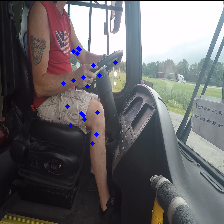

Left Upper arm angle: 1.3639275316029185
Upper arm Flexion
Corresponding Score: 1
Right Upper arm angle: -0.4034847350587501
Upper arm Flexion
Corresponding Score: 1
Func trunk angle: -5.440332031005509
right view image
Upper body lean angle: 5.440332031005509
Operator not leaned
Func lower arm angle: -7.853313301978219
Left Lower arm angle: 172.14668669802177
Lower arm flexion
Corresponding Score: 2
Func lower arm angle: -55.775187392283506
Right Lower arm angle: 124.2248126077165
Lower arm flexion
Corresponding Score: 2
Left wrist posture
Func wrist angle: 171.90791740105539
wrist extension
Left wrist angle: 8.092082598944614
Corresponding Score: 2
Right wrist posture
Func wrist angle: 175.00323933542865
wrist extension
Right wrist angle: 4.9967606645713545
Corresponding Score: 2
Left Wrist Twist Score: 1
Right Wrist Twist Score: 1
Func neck angle: 165.67900881847424
View of the image: right
right view
Neck flexion
Neck angle: 14.320991181525756
Neck Flexion: True
Corresponding Score

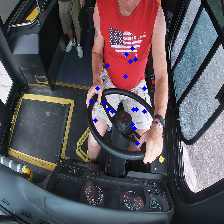

Is Left Shoulder Abducted: False
Is Right Shoulder Abducted: False
Is left Shoulder raised: False
Is right Shoulder raised: False
Final left upper arm score: 1
Final right upper arm score: 1
front view with right arm towards left side of image
is lower arm working midline False
Final left lower arm score: 2
Final right lower arm score: 2
Is left wrist bent away from mid: False
Is right wrist bent away from mid: False
32 14
Func neck side bent angle: 169.2911607738001
is neck twisted: True
Neck Score updated due to neck twisting: 3
is neck side bending: True
Neck Score updated due to side bending: 4
Func trunk side bend angle: 148.1340223063963
Trunk side bend angle: 31.865977693603696
is trunk side bent: True
Trunk Score updated due to side bending: 3
68 39
Trunk side twist result can not be relied because of side bent
Strong probability of trunk twisting
is trunk twist: True
Trunk Score updated due to twisting: 4
143.0 120.0
is leg supported: False
Corresponding Score: 2
Finding postu

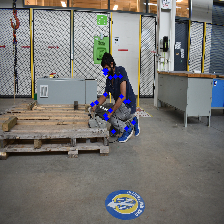

Left Upper arm angle: 14.882266398945177
Upper arm Flexion
Corresponding Score: 1
Right Upper arm angle: 48.39492354211827
Upper arm Flexion
Corresponding Score: 3
Func trunk angle: -25.14478563067895
left view image
Upper body lean angle: 25.14478563067895
Operator leaned
Upper arm score updated due to lean posture: 0
Func lower arm angle: 138.9803681865192
Left Lower arm angle: 41.0196318134808
Lower arm flexion
Corresponding Score: 2
Func lower arm angle: 148.02307967060497
Right Lower arm angle: 31.97692032939503
Lower arm flexion
Corresponding Score: 2
Left wrist posture
Func wrist angle: 173.15722658736905
wrist extension
Left wrist angle: 6.842773412630947
Corresponding Score: 2
Right wrist posture
Func wrist angle: 164.9315118405078
wrist extension
Right wrist angle: 15.068488159492205
Corresponding Score: 3
Left Wrist Twist Score: 1
Right Wrist Twist Score: 1
Func neck angle: -145.2133684525414
View of the image: left
left view
Neck flexion
Neck angle: 34.7866315474586
Neck Fl

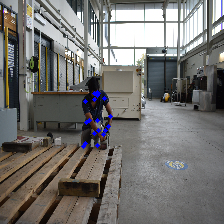

Is Left Shoulder Abducted: False
Is Right Shoulder Abducted: False
Is left Shoulder raised: False
Is right Shoulder raised: False
Left Upper arm score was 1 and made 0 because posture is leaned and rested
Final left upper arm score: 1
Final right upper arm score: 2
front view with right arm towards left side of image
is lower arm working midline False
Final left lower arm score: 2
Final right lower arm score: 2
Is left wrist bent away from mid: False
Is right wrist bent away from mid: False
12 7
Func neck side bent angle: 164.74488129694222
is neck twisted: False
is neck side bending: True
Neck Score updated due to side bending: 4
Func trunk side bend angle: -171.0273733851036
Trunk side bend angle: 8.972626614896399
is trunk side bent: False
22 30
is trunk twist: True
Trunk Score updated due to twisting: 4
145.0 143.0
is leg supported: True
Corresponding Score: 1
Finding posture score for left side group A
1 2 2 1
Score A: 2
Finding posture score for right side group A
2 2 3 1
Score A

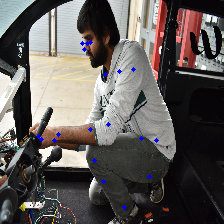

Left Upper arm angle: 42.3933577733304
Upper arm Flexion
Corresponding Score: 2
Right Upper arm angle: 44.612872245849054
Upper arm Flexion
Corresponding Score: 2
Func trunk angle: -23.60710964801856
left view image
Upper body lean angle: 23.60710964801856
Operator leaned
Upper arm score updated due to lean posture: 1
Func lower arm angle: 125.75388725443676
Left Lower arm angle: 54.24611274556324
Lower arm flexion
Corresponding Score: 2
Func lower arm angle: 122.24594199504395
Right Lower arm angle: 57.75405800495605
Lower arm flexion
Corresponding Score: 2
Left wrist posture
Func wrist angle: 174.40066066347944
wrist extension
Left wrist angle: 5.599339336520558
Corresponding Score: 2
Right wrist posture
Func wrist angle: 158.6104713530183
wrist extension
Right wrist angle: 21.389528646981688
Corresponding Score: 3
Left Wrist Twist Score: 1
Right Wrist Twist Score: 1
Func neck angle: -155.29616813340712
View of the image: left
left view
Neck flexion
Neck angle: 24.70383186659288
Neck

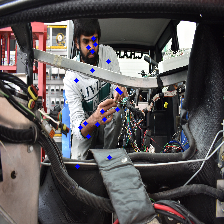

Is Left Shoulder Abducted: False
Is Right Shoulder Abducted: False
Is left Shoulder raised: False
Is right Shoulder raised: False
Final left upper arm score: 1
Final right upper arm score: 1
front view with right arm towards left side of image
is lower arm working midline False
Final left lower arm score: 2
Final right lower arm score: 2
Is left wrist bent away from mid: False
Is right wrist bent away from mid: False
24 16
Func neck side bent angle: 175.50984443994068
is neck twisted: False
is neck side bending: False
Func trunk side bend angle: -149.3002774491856
Trunk side bend angle: 30.699722550814414
is trunk side bent: True
Trunk Score updated due to side bending: 4
40 66
Trunk side twist result can not be relied because of side bent
Strong probability of trunk twisting
is trunk twist: True
Trunk Score updated due to twisting: 5
157.0 136.0
is leg supported: False
Corresponding Score: 2
Finding posture score for left side group A
1 2 2 1
Score A: 2
Finding posture score for right

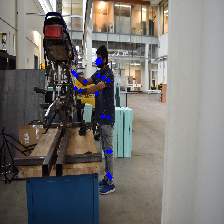

Left Upper arm angle: 42.70938995736147
Upper arm Flexion
Corresponding Score: 2
Right Upper arm angle: 70.79705723513189
Upper arm Flexion
Corresponding Score: 3
Func trunk angle: -2.935673446421172
left view image
Upper body lean angle: 2.935673446421172
Operator not leaned
Func lower arm angle: 122.08973468120635
Left Lower arm angle: 57.91026531879365
Lower arm flexion
Corresponding Score: 2
Func lower arm angle: 121.53479190518829
Right Lower arm angle: 58.465208094811715
Lower arm flexion
Corresponding Score: 2
Left wrist posture
Func wrist angle: 168.8182457898033
wrist extension
Left wrist angle: 11.181754210196686
Corresponding Score: 2
Right wrist posture
Func wrist angle: 168.69006752597977
wrist extension
Right wrist angle: 11.30993247402023
Corresponding Score: 2
Left Wrist Twist Score: 1
Right Wrist Twist Score: 1
Func neck angle: -168.8994299784947
View of the image: left
left view
Neck flexion
Neck angle: 11.100570021505291
Neck Flexion: True
Corresponding Score: 2
Func

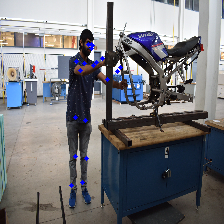

61.0 70.0
Is Left Shoulder Abducted: False
Is Right Shoulder Abducted: True
right upper arm score updated due to abduction: 4
Is left Shoulder raised: False
Is right Shoulder raised: False
Final left upper arm score: 2
Final right upper arm score: 4
front view with right arm towards left side of image
is lower arm working midline False
Final left lower arm score: 2
Final right lower arm score: 2
Is left wrist bent away from mid: False
Is right wrist bent away from mid: False
15 2
Func neck side bent angle: 163.9099045613421
is neck twisted: False
is neck side bending: True
Neck Score updated due to side bending: 3
Func trunk side bend angle: 166.75948008481282
Trunk side bend angle: 13.240519915187178
is trunk side bent: False
59 55
is trunk twist: False
182.0 185.0
is leg supported: True
Corresponding Score: 1
Finding posture score for left side group A
2 2 2 1
Score A: 3
Finding posture score for right side group A
4 2 2 1
Score A: 4
Finding posture score for group B
3 2 1
Score B: 3

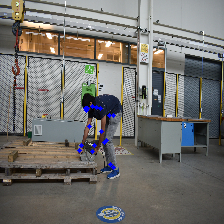

Left Upper arm angle: 59.20969131199447
Upper arm Flexion
Corresponding Score: 3
Right Upper arm angle: 70.6334945790005
Upper arm Flexion
Corresponding Score: 3
Func trunk angle: -61.927513064147035
left view image
Upper body lean angle: 61.927513064147035
Operator leaned
Upper arm score updated due to lean posture: 2
Func lower arm angle: 150.94539590092285
Left Lower arm angle: 29.054604099077153
Lower arm flexion
Corresponding Score: 2
Func lower arm angle: 165.6971114320306
Right Lower arm angle: 14.302888567969404
Lower arm flexion
Corresponding Score: 2
Left wrist posture
Func wrist angle: -171.86989764584405
wrist flexion
Left wrist angle: 8.130102354155952
Corresponding Score: 2
Right wrist posture
Func wrist angle: -178.96775530843428
wrist flexion
Right wrist angle: 1.0322446915657224
Corresponding Score: 2
Left Wrist Twist Score: 1
Right Wrist Twist Score: 1
Func neck angle: -145.91850710665253
View of the image: left
left view
Neck flexion
Neck angle: 34.08149289334747
Nec

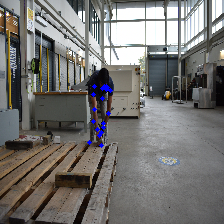

Is Left Shoulder Abducted: False
Is Right Shoulder Abducted: False
Is left Shoulder raised: False
Is right Shoulder raised: False
Final left upper arm score: 2
Final right upper arm score: 2
front view with right arm towards left side of image
is lower arm working midline False
Final left lower arm score: 2
Final right lower arm score: 2
Is left wrist bent away from mid: False
Is right wrist bent away from mid: False
12 4
Func neck side bent angle: 143.32024251736945
is neck twisted: False
is neck side bending: True
Neck Score updated due to side bending: 4
Func trunk side bend angle: 165.96375653207352
Trunk side bend angle: 14.036243467926482
is trunk side bent: False
14 17
is trunk twist: False
145.0 142.0
is leg supported: True
Corresponding Score: 1
Finding posture score for left side group A
2 2 2 1
Score A: 3
Finding posture score for right side group A
2 2 2 1
Score A: 3
Finding posture score for group B
4 4 1
Score B: 7
Finding grand score for left side
3 7
Grand score is: 0
F

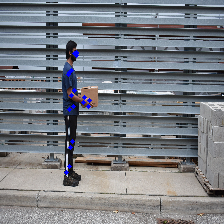

Left Upper arm angle: -5.3509354900838995
Upper arm Flexion
Corresponding Score: 1
Right Upper arm angle: -6.493525312539259
Upper arm Flexion
Corresponding Score: 1
Func trunk angle: -2.419509216656336
right view image
Upper body lean angle: 2.419509216656336
Operator not leaned
Func lower arm angle: -133.5227858085068
Left Lower arm angle: 46.4772141914932
Lower arm flexion
Corresponding Score: 2
Func lower arm angle: -128.38653951768526
Right Lower arm angle: 51.613460482314736
Lower arm flexion
Corresponding Score: 2
Left wrist posture
Func wrist angle: -175.97173633351485
wrist flexion
Left wrist angle: 4.028263666485145
Corresponding Score: 2
Right wrist posture
Func wrist angle: 171.5966289094392
wrist extension
Right wrist angle: 8.403371090560796
Corresponding Score: 2
Left Wrist Twist Score: 1
Right Wrist Twist Score: 1
Func neck angle: 159.5763291774303
View of the image: right
right view
Neck flexion
Neck angle: 20.423670822569704
Neck Flexion: True
Corresponding Score: 3
F

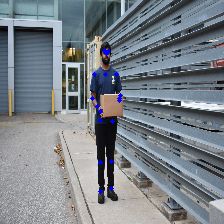

Is Left Shoulder Abducted: False
Is Right Shoulder Abducted: False
Is left Shoulder raised: False
Is right Shoulder raised: False
Final left upper arm score: 1
Final right upper arm score: 1
front view with right arm towards left side of image
is lower arm working midline False
Final left lower arm score: 2
Final right lower arm score: 2
Is left wrist bent away from mid: False
Is right wrist bent away from mid: False
12 10
Func neck side bent angle: 173.57359368962548
is neck twisted: False
is neck side bending: True
Neck Score updated due to side bending: 4
Func trunk side bend angle: 180.0
Trunk side bend angle: 0.0
is trunk side bent: False
50 48
is trunk twist: False
188.0 191.0
is leg supported: True
Corresponding Score: 1
Finding posture score for left side group A
1 2 2 1
Score A: 2
Finding posture score for right side group A
1 2 2 1
Score A: 2
Finding posture score for group B
4 2 1
Score B: 5
Finding grand score for left side
2 5
Grand score is: 6
Finding grand score for righ

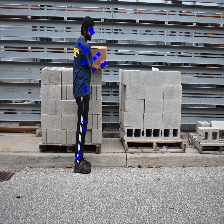

Left Upper arm angle: -8.891596381615791
Upper arm Flexion
Corresponding Score: 1
Right Upper arm angle: -24.26575036208218
Upper arm Flexion
Corresponding Score: 2
Func trunk angle: -2.759107658620274
right view image
Upper body lean angle: 2.759107658620274
Operator not leaned
Func lower arm angle: -83.72270151040246
Left Lower arm angle: 96.27729848959754
Lower arm flexion
Corresponding Score: 1
Func lower arm angle: -86.26860300083955
Right Lower arm angle: 93.73139699916045
Lower arm flexion
Corresponding Score: 1
Left wrist posture
Func wrist angle: -156.80140948635182
wrist flexion
Left wrist angle: 23.198590513648185
Corresponding Score: 3
Right wrist posture
Func wrist angle: -172.8749836510982
wrist flexion
Right wrist angle: 7.125016348901795
Corresponding Score: 2
Left Wrist Twist Score: 1
Right Wrist Twist Score: 1
Func neck angle: 151.89471639943307
View of the image: right
right view
Neck flexion
Neck angle: 28.105283600566935
Neck Flexion: True
Corresponding Score: 3
Fu

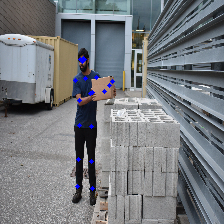

Is Left Shoulder Abducted: False
Is Right Shoulder Abducted: False
Is left Shoulder raised: False
Is right Shoulder raised: False
Final left upper arm score: 1
Final right upper arm score: 2
front view with right arm towards left side of image
is lower arm working midline False
Final left lower arm score: 1
Final right lower arm score: 1
Is left wrist bent away from mid: False
Is right wrist bent away from mid: False
7 14
Func neck side bent angle: -172.26547707442302
is neck twisted: False
is neck side bending: True
Neck Score updated due to side bending: 4
Func trunk side bend angle: -171.86989764584405
Trunk side bend angle: 8.130102354155952
is trunk side bent: False
48 50
is trunk twist: False
188.0 186.0
is leg supported: True
Corresponding Score: 1
Finding posture score for left side group A
1 1 3 1
Score A: 2
Finding posture score for right side group A
2 1 2 1
Score A: 3
Finding posture score for group B
4 2 1
Score B: 5
Finding grand score for left side
2 5
Grand score is: 6


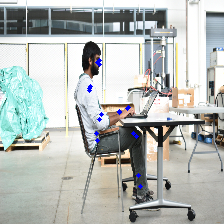

Left Upper arm angle: -14.172731369216093
Upper arm Flexion
Corresponding Score: 1
Right Upper arm angle: -9.935329116746367
Upper arm Flexion
Corresponding Score: 1
Func trunk angle: -8.212780189285885
right view image
Upper body lean angle: 8.212780189285885
Operator not leaned
Func lower arm angle: -101.98541411907973
Left Lower arm angle: 78.01458588092027
Lower arm flexion
Corresponding Score: 1
Func lower arm angle: -89.73555981837995
Right Lower arm angle: 90.26444018162005
Lower arm flexion
Corresponding Score: 1
Left wrist posture
Func wrist angle: -165.49983323344745
wrist flexion
Left wrist angle: 14.500166766552553
Corresponding Score: 2
Right wrist posture
Func wrist angle: -172.72499504211075
wrist flexion
Right wrist angle: 7.2750049578892515
Corresponding Score: 2
Left Wrist Twist Score: 1
Right Wrist Twist Score: 1
Func neck angle: 153.0458793655214
View of the image: right
right view
Neck flexion
Neck angle: 26.954120634478613
Neck Flexion: True
Corresponding Score: 3

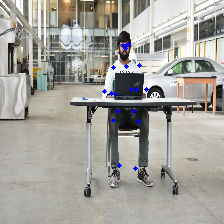

Is Left Shoulder Abducted: False
Is Right Shoulder Abducted: False
Is left Shoulder raised: False
Is right Shoulder raised: False
Final left upper arm score: 1
Final right upper arm score: 1
front view with right arm towards left side of image
is lower arm working midline False
Final left lower arm score: 1
Final right lower arm score: 1
Is left wrist bent away from mid: False
Is right wrist bent away from mid: False
12 14
Func neck side bent angle: 179.9091024884538
is neck twisted: False
is neck side bending: False
Func trunk side bend angle: -175.6012946450045
Trunk side bend angle: 4.3987053549955135
is trunk side bent: False
48 50
is trunk twist: False
168.0 165.0
is leg supported: True
Corresponding Score: 1
Finding posture score for left side group A
1 1 2 1
Score A: 2
Finding posture score for right side group A
1 1 2 1
Score A: 2
Finding posture score for group B
3 2 1
Score B: 3
Finding grand score for left side
2 3
Grand score is: 5
Finding grand score for right side
2 3
Gra

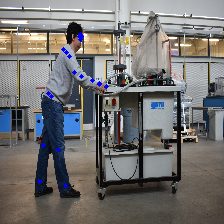

Left Upper arm angle: -44.38467519006386
Upper arm Flexion
Corresponding Score: 2
Right Upper arm angle: -55.19150185002769
Upper arm Flexion
Corresponding Score: 3
Func trunk angle: 21.44773632710535
right view image
Upper body lean angle: 21.44773632710535
Operator leaned
Upper arm score updated due to lean posture: 1
Func lower arm angle: -139.52245414640203
Left Lower arm angle: 40.477545853597974
Lower arm flexion
Corresponding Score: 2
Func lower arm angle: -144.9262455066517
Right Lower arm angle: 35.073754493348304
Lower arm flexion
Corresponding Score: 2
Left wrist posture
Func wrist angle: -179.23610153907003
wrist flexion
Left wrist angle: 0.7638984609299655
Corresponding Score: 2
Right wrist posture
Func wrist angle: -171.98290692634467
wrist flexion
Right wrist angle: 8.017093073655332
Corresponding Score: 2
Left Wrist Twist Score: 1
Right Wrist Twist Score: 1
Func neck angle: 163.35896344613002
View of the image: right
right view
Neck flexion
Neck angle: 16.64103655386998

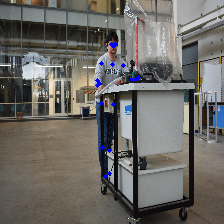

Is Left Shoulder Abducted: False
Is Right Shoulder Abducted: False
Is left Shoulder raised: False
Is right Shoulder raised: False
Final left upper arm score: 1
Final right upper arm score: 2
front view with right arm towards left side of image
is lower arm working midline False
Final left lower arm score: 2
Final right lower arm score: 2
Is left wrist bent away from mid: False
Is right wrist bent away from mid: False
12 10
Func neck side bent angle: -178.4963310982929
is neck twisted: False
is neck side bending: False
Func trunk side bend angle: 174.8055710922652
Trunk side bend angle: 5.194428907734789
is trunk side bent: False
42 43
is trunk twist: False
173.0 176.0
is leg supported: True
Corresponding Score: 1
Finding posture score for left side group A
1 2 2 1
Score A: 2
Finding posture score for right side group A
2 2 2 1
Score A: 3
Finding posture score for group B
2 3 1
Score B: 4
Finding grand score for left side
2 4
Grand score is: 6
Finding grand score for right side
3 4
Gran

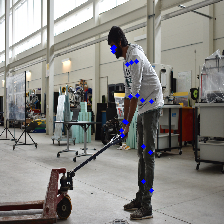

Left Upper arm angle: 18.871360901687176
Upper arm Flexion
Corresponding Score: 1
Right Upper arm angle: 17.264039905185243
Upper arm Flexion
Corresponding Score: 1
Func trunk angle: -21.540975918538443
left view image
Upper body lean angle: 21.540975918538443
Operator leaned
Upper arm score updated due to lean posture: 0
Func lower arm angle: 156.14896986002125
Left Lower arm angle: 23.851030139978747
Lower arm flexion
Corresponding Score: 2
Func lower arm angle: 161.148441676349
Right Lower arm angle: 18.851558323651005
Lower arm flexion
Corresponding Score: 2
Left wrist posture
Func wrist angle: -174.93638314696992
wrist flexion
Left wrist angle: 5.063616853030084
Corresponding Score: 2
Right wrist posture
Func wrist angle: 175.0607844578738
wrist extension
Right wrist angle: 4.939215542126192
Corresponding Score: 2
Left Wrist Twist Score: 1
Right Wrist Twist Score: 1
Func neck angle: -151.34654701080368
View of the image: left
left view
Neck flexion
Neck angle: 28.653452989196325
N

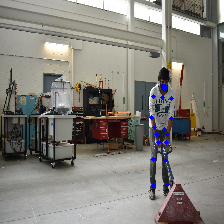

Is Left Shoulder Abducted: False
Is Right Shoulder Abducted: False
Is left Shoulder raised: False
Is right Shoulder raised: False
Right Upper arm score was 1 and made 0 because posture is leaned and rested
Left Upper arm score was 1 and made 0 because posture is leaned and rested
Final left upper arm score: 1
Final right upper arm score: 1
front view with right arm towards left side of image
is lower arm working midline False
Final left lower arm score: 2
Final right lower arm score: 2
Is left wrist bent away from mid: False
Is right wrist bent away from mid: False
11 7
Func neck side bent angle: 172.72327408636943
is neck twisted: False
is neck side bending: True
Neck Score updated due to side bending: 4
Func trunk side bend angle: 173.6598082540901
Trunk side bend angle: 6.340191745909891
is trunk side bent: False
34 33
is trunk twist: False
184.0 185.0
is leg supported: True
Corresponding Score: 1
Finding posture score for left side group A
1 2 2 1
Score A: 2
Finding posture score f

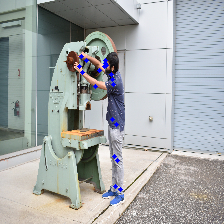

Left Upper arm angle: 87.9489615829091
Upper arm Flexion
Corresponding Score: 3
Right Upper arm angle: 109.70797884297873
Upper arm Flexion
Corresponding Score: 4
Func trunk angle: -2.6942842898561006
left view image
Upper body lean angle: 2.6942842898561006
Operator not leaned
Func lower arm angle: 126.53871185742865
Left Lower arm angle: 53.46128814257135
Lower arm flexion
Corresponding Score: 2
Func lower arm angle: 160.86635679409451
Right Lower arm angle: 19.133643205905486
Lower arm flexion
Corresponding Score: 2
Left wrist posture
Func wrist angle: 163.68614757373945
wrist extension
Left wrist angle: 16.313852426260553
Corresponding Score: 3
Right wrist posture
Func wrist angle: 178.9087837747374
wrist extension
Right wrist angle: 1.091216225262599
Corresponding Score: 2
Left Wrist Twist Score: 1
Right Wrist Twist Score: 1
Func neck angle: -161.96872542429557
View of the image: left
left view
Neck flexion
Neck angle: 18.03127457570443
Neck Flexion: True
Corresponding Score: 2
Fu

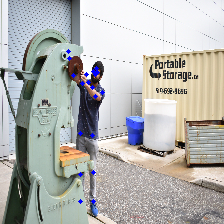

92.0 96.0
83.0 75.0
Is Left Shoulder Abducted: True
left upper arm score updated due to abduction: 4
Is Right Shoulder Abducted: True
right upper arm score updated due to abduction: 5
Is left Shoulder raised: False
Is right Shoulder raised: False
Final left upper arm score: 4
Final right upper arm score: 5
front view with right arm towards left side of image
is lower arm working midline False
Final left lower arm score: 2
Final right lower arm score: 2
Is left wrist bent away from mid: False
Is right wrist bent away from mid: False
15 7
Func neck side bent angle: 175.4637213202644
is neck twisted: False
is neck side bending: False
Func trunk side bend angle: 155.77225468204585
Trunk side bend angle: 24.227745317954145
is trunk side bent: True
Trunk Score updated due to side bending: 3
52 46
is trunk twist: False
201.0 201.0
is leg supported: True
Corresponding Score: 1
Finding posture score for left side group A
4 2 3 1
Score A: 4
Finding posture score for right side group A
5 2 2 1
Sc

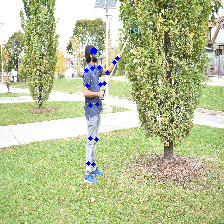

Left Upper arm angle: -61.08867485083362
Upper arm Flexion
Corresponding Score: 3
Right Upper arm angle: 2.7057269173666323
Upper arm Flexion
Corresponding Score: 1
Func trunk angle: -1.5911402711945872
right view image
Upper body lean angle: 1.5911402711945872
Operator not leaned
Func lower arm angle: -92.98663699047518
Left Lower arm angle: 87.01336300952482
Lower arm flexion
Corresponding Score: 1
Func lower arm angle: -89.41536947929482
Right Lower arm angle: 90.58463052070518
Lower arm flexion
Corresponding Score: 1
Left wrist posture
Func wrist angle: 178.12212255271464
wrist extension
Left wrist angle: 1.877877447285357
Corresponding Score: 2
Right wrist posture
Func wrist angle: -170.36246188706906
wrist flexion
Right wrist angle: 9.63753811293094
Corresponding Score: 2
Left Wrist Twist Score: 1
Right Wrist Twist Score: 1
Func neck angle: 172.3998537713109
View of the image: right
right view
Neck flexion
Neck angle: 7.600146228689113
Neck Flexion: True
Corresponding Score: 1
Fu

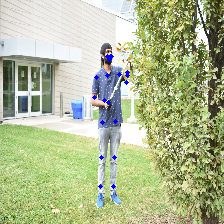

74.0 82.0
Is Left Shoulder Abducted: True
left upper arm score updated due to abduction: 4
Is Right Shoulder Abducted: False
Is left Shoulder raised: False
Is right Shoulder raised: False
Final left upper arm score: 4
Final right upper arm score: 1
front view with right arm towards left side of image
is lower arm working midline False
Final left lower arm score: 1
Final right lower arm score: 1
Is left wrist bent away from mid: False
Is right wrist bent away from mid: False
13 10
Func neck side bent angle: 171.44887619992085
is neck twisted: False
is neck side bending: True
Neck Score updated due to side bending: 2
Func trunk side bend angle: -172.56859202882748
Trunk side bend angle: 7.4314079711725185
is trunk side bent: False
47 50
is trunk twist: False
186.0 186.0
is leg supported: True
Corresponding Score: 1
Finding posture score for left side group A
4 1 2 1
Score A: 4
Finding posture score for right side group A
1 1 2 1
Score A: 2
Finding posture score for group B
2 2 1
Score B:

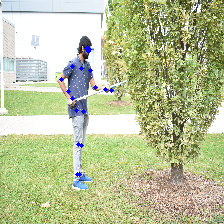

Left Upper arm angle: -26.078326894401577
Upper arm Flexion
Corresponding Score: 2
Right Upper arm angle: 45.43078721700863
Upper arm Flexion
Corresponding Score: 3
Func trunk angle: 2.0213649403560163
right view image
Upper body lean angle: 2.0213649403560163
Operator not leaned
Func lower arm angle: -117.699472808055
Left Lower arm angle: 62.300527191944994
Lower arm flexion
Corresponding Score: 1
Func lower arm angle: -109.50720452719692
Right Lower arm angle: 70.49279547280308
Lower arm flexion
Corresponding Score: 1
Left wrist posture
Func wrist angle: -178.1523897340054
wrist flexion
Left wrist angle: 1.8476102659946037
Corresponding Score: 2
Right wrist posture
Func wrist angle: 179.48844413341297
wrist extension
Right wrist angle: 0.511555866587031
Corresponding Score: 2
Left Wrist Twist Score: 1
Right Wrist Twist Score: 1
Func neck angle: 161.46531972077253
View of the image: right
right view
Neck flexion
Neck angle: 18.534680279227473
Neck Flexion: True
Corresponding Score: 2

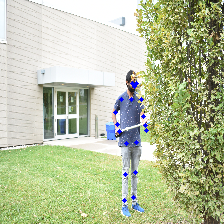

Is Left Shoulder Abducted: False
Is Right Shoulder Abducted: False
Is left Shoulder raised: False
Is right Shoulder raised: False
Final left upper arm score: 2
Final right upper arm score: 3
front view with right arm towards left side of image
is lower arm working midline False
Final left lower arm score: 1
Final right lower arm score: 1
Is left wrist bent away from mid: False
Is right wrist bent away from mid: False
13 7
Func neck side bent angle: 164.57783868126134
is neck twisted: False
is neck side bending: True
Neck Score updated due to side bending: 3
Func trunk side bend angle: 180.0
Trunk side bend angle: 0.0
is trunk side bent: False
45 46
is trunk twist: False
197.0 200.0
is leg supported: True
Corresponding Score: 1
Finding posture score for left side group A
2 1 2 1
Score A: 3
Finding posture score for right side group A
3 1 2 1
Score A: 4
Finding posture score for group B
3 2 1
Score B: 3
Finding grand score for left side
3 3
Grand score is: 6
Finding grand score for right

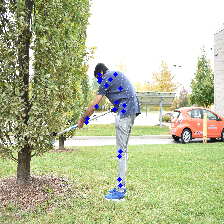

Left Upper arm angle: 58.64185672126436
Upper arm Flexion
Corresponding Score: 3
Right Upper arm angle: -3.4646178010263675
Upper arm Flexion
Corresponding Score: 1
Func trunk angle: -24.519642688190757
left view image
Upper body lean angle: 24.519642688190757
Operator leaned
Upper arm score updated due to lean posture: 2
Func lower arm angle: 168.5934474160276
Left Lower arm angle: 11.406552583972399
Lower arm flexion
Corresponding Score: 2
Func lower arm angle: 144.40078004102384
Right Lower arm angle: 35.599219958976164
Lower arm flexion
Corresponding Score: 2
Left wrist posture
Func wrist angle: -157.16634582208246
wrist flexion
Left wrist angle: 22.833654177917538
Corresponding Score: 3
Right wrist posture
Func wrist angle: 180.0
wrist extension
Right wrist angle: 0.0
Corresponding Score: 1
Left Wrist Twist Score: 1
Right Wrist Twist Score: 1
Func neck angle: -138.9635974686073
View of the image: left
left view
Neck flexion
Neck angle: 41.036402531392696
Neck Flexion: True
Corresp

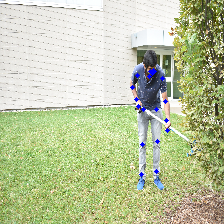

Is Left Shoulder Abducted: False
Is Right Shoulder Abducted: False
Is left Shoulder raised: False
Is right Shoulder raised: False
Right Upper arm score was 1 and made 0 because posture is leaned and rested
Final left upper arm score: 2
Final right upper arm score: 1
front view with right arm towards left side of image
is lower arm working midline False
Final left lower arm score: 2
Final right lower arm score: 2
Is left wrist bent away from mid: False
Is right wrist bent away from mid: False
15 10
Func neck side bent angle: 149.74356283647072
is neck twisted: False
is neck side bending: True
Neck Score updated due to side bending: 4
Func trunk side bend angle: 173.15722658736905
Trunk side bend angle: 6.842773412630947
is trunk side bent: False
38 36
is trunk twist: False
171.0 174.0
is leg supported: True
Corresponding Score: 1
Finding posture score for left side group A
2 2 3 1
Score A: 3
Finding posture score for right side group A
1 2 1 1
Score A: 2
Finding posture score for group 

In [ ]:
test_img_folder_list = [join(test_img_root_path, f) for f in listdir(test_img_root_path) if not isfile(join(test_img_root_path, f))]
print('No of folders in test image directory: '+str(len(test_img_folder_list)))
for test_img_folder in test_img_folder_list:
  test_img_path_list = [join(test_img_folder, f) for f in listdir(test_img_folder) if isfile(join(test_img_folder, f))]
  for i in range(2):
    img_view_flag = test_img_path_list[i].rsplit(sep='.',maxsplit=1)[0].rsplit(sep='_',maxsplit=1)[1]
    if img_view_flag=='F':
      front_img = test_img_path_list[i]
    else:
      img_view = img_view_flag
      side_img = test_img_path_list[i]
  start_time_1 = time.time()
  plot_estimate_rula_score(front_img, side_img, img_view)
  elapsed_time_1 = time.time() - start_time_1
  print('Time taken to inference posture: ' + str(elapsed_time_1) + ' seconds')